In [35]:
import os,sys
from collections import defaultdict
import json
import numpy as np
import pickle
import matplotlib
from matplotlib import pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
PATH = '/home/eddyod/programming/pipeline_utility'
MESH_DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes'
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.imported_atlas_utilities import load_original_volume_all_known_structures_v3, get_centroid_3d, \
    load_alignment_results_v3, transform_points, average_location, \
    convert_to_original_name, name_unsided_to_color, paired_structures, \
    convert_to_left_name, convert_to_right_name, load_original_volume_v2, save_alignment_results_v3, \
    convert_transform_forms, transform_volume_v4, volume_to_polydata, singular_structures, \
    MESH_DIR, average_shape, convert_to_surround_name, \
    save_mesh_stl, get_surround_volume_v2, transform_volume_v4, launch_vtk, actor_mesh, high_contrast_colors, \
    add_axes, plot_centroid_means_and_covars_3d, all_known_structures_sided, load_data, \
    get_instance_mesh_filepath, images_to_volume_v2
from utilities.aligner_v3 import Aligner
from utilities.alignment_utility import convert_resolution_string_to_um
from utilities.conversion import *

In [3]:
INPUT_KEY_LOC = os.path.join(PATH, 'neuroglancer', 'structure_key_minimal.json')
NUM_STRUCTS = 49
with open(INPUT_KEY_LOC, 'r') as f:
    structures = json.load(f)
structures = list(structures.values())
structures = structures[0:9]

In [4]:
structures = ['IC', 'SC']

In [5]:
atlas_name = 'atlasV7'
fixed_brain_name = 'MD589'
moving_brain_names = ['MD585', 'MD594']
resolution = '10.0um'
resolution_um = 10.0
structure_centroids_all_brains_um_wrt_fixed = []
fixed_brain_spec = {'name': fixed_brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}

In [6]:
fixed_brain = load_original_volume_all_known_structures_v3(stack_spec=fixed_brain_spec, structures=structures, 
                                                           in_bbox_wrt='wholebrain')
fixed_brain_structure_centroids = get_centroid_3d(fixed_brain)
print('fixed_brain_structure_centroids', fixed_brain_structure_centroids)
fixed_brain_structure_centroids_um = {s: c * resolution_um for s, c in fixed_brain_structure_centroids.items()}
print('fixed_brain_structure_centroids_um', fixed_brain_structure_centroids_um)
structure_centroids_all_brains_um_wrt_fixed.append(fixed_brain_structure_centroids_um)

Prior structure/index map not found. Generating a new one.


vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix SC
fixed_brain_structure_centroids {'IC': array([1184.30128992,  308.85017456,  433.34325169]), 'SC': array([1075.36825329,  298.88313569,  430.98862599])}
fixed_brain_structure_centroids_um {'IC': array([11843.01289921,  3088.50174556,  4333.43251686]), 'SC': array([10753.68253291,  2988.83135691,  4309.88625988])}


## Compute instance centroids

In [7]:
for brain_m in moving_brain_names:
    moving_brain_spec = {'name': brain_m, 'vol_type': 'annotationAsScore', 'resolution': resolution}
    print('Brain', moving_brain_spec)
    moving_brain = load_original_volume_all_known_structures_v3(stack_spec=moving_brain_spec, 
                                                                structures=structures, in_bbox_wrt='wholebrain')
    alignment_spec = dict(stack_m=moving_brain_spec, stack_f=fixed_brain_spec, warp_setting=109)
    moving_brain_structure_centroids_input_resol = get_centroid_3d(moving_brain)
    # Load registration.
    # Alignment results fp: os.path.join(reg_root_dir, alignment_spec['stack_m']['name'], warp_basename, warp_basename + '_' + what + '.' + ext)
    transform_parameters_moving_brain_to_fixed_brain = load_alignment_results_v3(alignment_spec=alignment_spec, what='parameters')
    # Transform moving brains into alignment with the fixed brain.
    transformed_moving_brain_structure_centroids_input_resol_wrt_fixed = \
    dict(list(zip(list(moving_brain_structure_centroids_input_resol.keys()),
                  transform_points(pts=list(moving_brain_structure_centroids_input_resol.values()),
                                   transform=transform_parameters_moving_brain_to_fixed_brain))))

    transformed_moving_brain_structure_centroids_um_wrt_fixed = \
        {s: c * resolution_um for s, c in
        list(transformed_moving_brain_structure_centroids_input_resol_wrt_fixed.items())}

    structure_centroids_all_brains_um_wrt_fixed.append(transformed_moving_brain_structure_centroids_um_wrt_fixed)


Brain {'name': 'MD585', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix SC


Prior structure/index map not found. Generating a new one.


INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_registration_parameters/MD585/10.0um_annotationAsScoreVolume_warp109_10.0um_annotationAsScoreVolume/parameters.json
Brain {'name': 'MD594', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}
vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix SC


Prior structure/index map not found. Generating a new one.


INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_registration_parameters/MD594/10.0um_annotationAsScoreVolume_warp109_10.0um_annotationAsScoreVolume/parameters.json


In [8]:
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed = defaultdict(list)
for sc in structure_centroids_all_brains_um_wrt_fixed:
    for k, c in sc.items():
        structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed[k].append(c)
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed.default_factory = None

## Compute standard centroids

In [9]:
nominal_centroids_wrt_canonicalAtlasSpace_um, \
instance_centroids_wrt_canonicalAtlasSpace_um, \
canonical_center_wrt_fixed_um, \
canonical_normal, \
transform_matrix_to_canonicalAtlasSpace_um = \
average_location(structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed)

('Mid-sagittal plane normal vector =', array([-0.02276253,  0.08796512,  0.99586345]), '@ Mid-sagittal plane anchor wrt fixed wholebrain =', array([11176.16223759,  3171.83782533,  4484.31495654]))
('Angular deviation of the mid sagittal plane normal around y axis (degree) =', 5.213228446103473)


In [10]:
colors = {name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
                                        for name_s in instance_centroids_wrt_canonicalAtlasSpace_um.keys()}

No handles with labels found to put in legend.


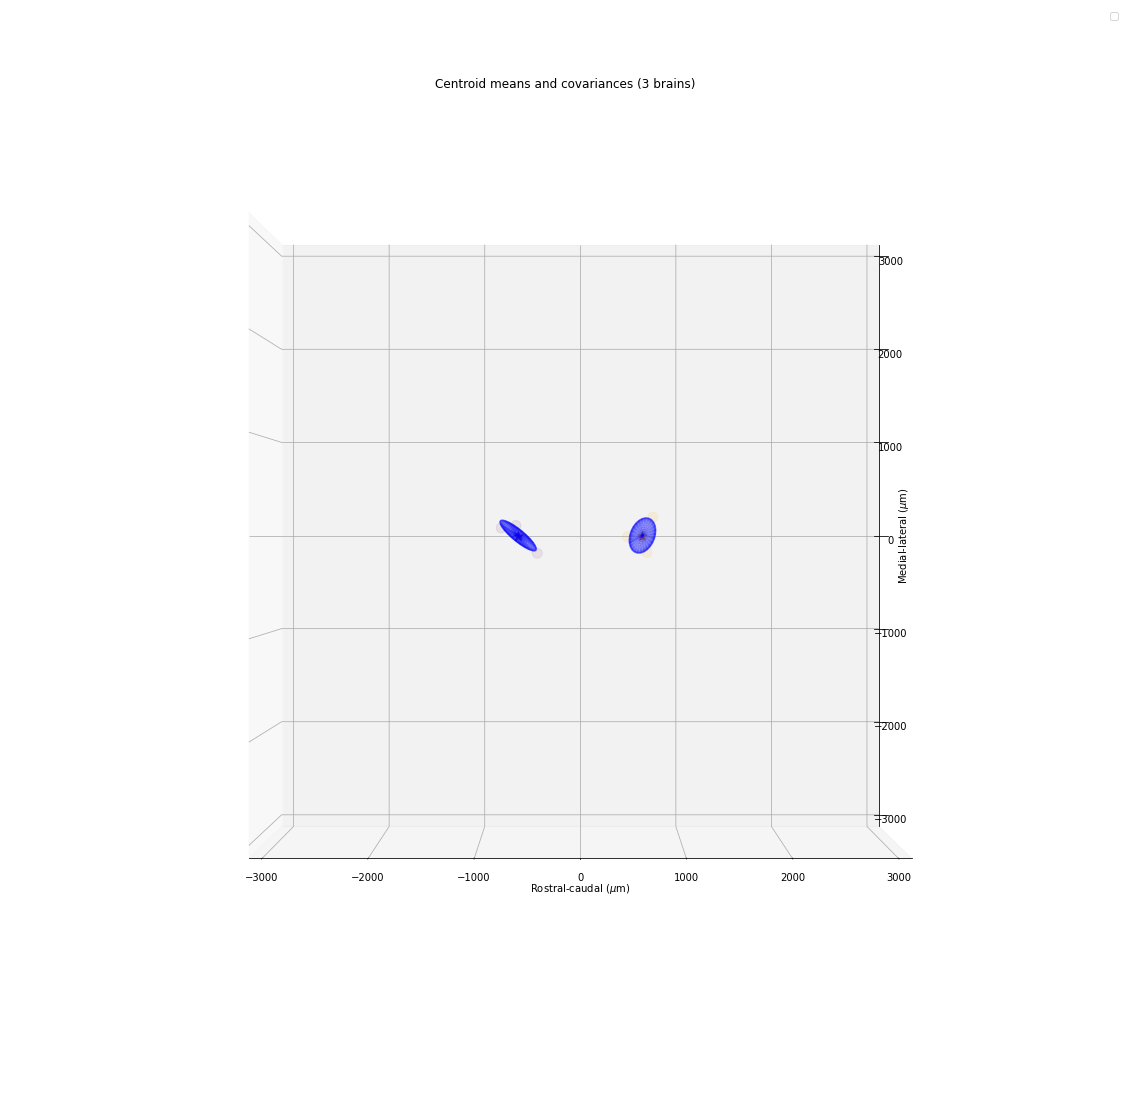

In [11]:
plot_centroid_means_and_covars_3d(instance_centroids=instance_centroids_wrt_canonicalAtlasSpace_um,
                                 nominal_locations=nominal_centroids_wrt_canonicalAtlasSpace_um,
                                 canonical_centroid=(0,0,0),
                                  show_canonical_centroid=False,
                                  canonical_normal=[0,0,1],
                                 colors=colors,
                                 xlim=[-3000, 3000],
                                 ylim=[-3000, 3000],
                                 zlim=[-3000, 3000],
                                 xlabel='Rostral-caudal ($\mu$m)',
                                 ylabel='',
                                 zlabel='Medial-lateral ($\mu$m)',
                                 title='Centroid means and covariances (3 brains)')

In [12]:
filepath = os.path.join(MESH_DIR, atlas_name, '1um_meanPositions.pkl')
with open(filepath, 'wb') as f:
    pickle.dump(nominal_centroids_wrt_canonicalAtlasSpace_um, f)

In [13]:
filepath = os.path.join(MESH_DIR, atlas_name, 'canonicalCentroid_wrt_fixedWholebrain.txt')
np.savetxt(filepath, canonical_center_wrt_fixed_um)

In [14]:
reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')

In [15]:
# Note that all shapes have voxel resolution matching input resolution (10.0 micron).
for structure in structures:
    # for structure in all_known_structures:
    # Load instance volumes.
    instance_volumes = []
    instance_source = []

    if structure in paired_structures:
        left_name = convert_to_left_name(structure)
        right_name = convert_to_right_name(structure)
    else:
        left_name = structure
        right_name = structure

    for brain_name in [fixed_brain_name] + moving_brain_names:
        brain_spec = {'name': brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}
        right_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec,
                                                        structure=right_name,
                                                        return_origin_instead_of_bbox=True,
                                                        crop_to_minimal=True)
        instance_volumes.append(right_instance_vol)  # if right, do not mirror
        instance_source.append((brain_name, 'R'))

        left_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec,
                                                       structure=left_name,
                                                       return_origin_instead_of_bbox=True,
                                                       crop_to_minimal=True)
        instance_volumes.append(left_instance_vol[..., ::-1])  # if left, mirror
        instance_source.append((brain_name, 'L'))

   # Use the first instance as registration target.
    # Register every other instance to the first instance.
    template_instance_volume = instance_volumes[0]
    template_instance_centroid_wrt_templateOrigin = get_centroid_3d(template_instance_volume).astype(np.int16)
    template_instance_wrt_templateCentroid = (template_instance_volume, - template_instance_centroid_wrt_templateOrigin)
    aligned_moving_instance_wrt_templateCentroid_all_instances = []

    for i in range(1, len(instance_volumes)):
        print('Registering {} instance {} to instance 0'.format(structure, i))
        # Compute transform.
        moving_instance_volume = instance_volumes[i]
        aligner = Aligner({0: template_instance_wrt_templateCentroid},
                          {0: (moving_instance_volume, np.array((0,0,0)))},
                          labelIndexMap_m2f={0:0},
                         verbose=False)
        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
        aligner.compute_gradient(smooth_first=True)
        lr = 1.
        ### max_iter_num was originally 100 and 1000
        print('Entering aligner optimzer')
        _, _ = aligner.optimize(tf_type='rigid',
                                history_len=100,
                                max_iter_num=2 if structure in ['SC', 'IC'] else 3,
                                grad_computation_sample_number=None,
                                full_lr=np.array([lr, lr, lr, 0.1, 0.1, 0.1]),
                                terminate_thresh_trans=.01)



        reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')
        save_alignment_results_v3(aligner=aligner,
                              select_best='max_value',
                              alignment_spec=dict(warp_setting=108,
                                                  stack_f=dict(name='%s_instance0' % structure, vol_type='annotationAsScore'),
                                                  stack_m=dict(name='%s_instance%d' % (structure, i),
                                                               vol_type='annotationAsScore')),
                              reg_root_dir=reg_root_dir)

        # Transform instances.
        T = convert_transform_forms(aligner=aligner, out_form=(3, 4), select_best='max_value')
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
            transform_volume_v4(volume=(moving_instance_volume, (0, 0, 0)), transform=T,
                                return_origin_instead_of_bbox=True)
        aligned_moving_instance_wrt_templateCentroid = (
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)
        aligned_moving_instance_wrt_templateCentroid_all_instances.append(aligned_moving_instance_wrt_templateCentroid)

    # Generate meshes for each instance.
    volume_origin_list = [template_instance_wrt_templateCentroid] + aligned_moving_instance_wrt_templateCentroid_all_instances
    instance_mesh_wrt_templateCentroid_all_instances = [volume_to_polydata(volume, num_simplify_iter=3, smooth=True)
        for volume, o in volume_origin_list]

    # Save meshes.
    for i, mesh_data in enumerate(instance_mesh_wrt_templateCentroid_all_instances):
        meshfile = '{}_{}_{}.stl'.format(resolution, structure, str(i))
        meshpath = os.path.join(MESH_DIR, atlas_name, 'aligned_instance_meshes', meshfile)
        #print('Save stl at {}'.format( meshpath))
        save_mesh_stl(mesh_data, meshpath)

    filename = '{}_sources.pkl'.format(structure)
    filepath = os.path.join(MESH_DIR, atlas_name, 'instance_sources', filename)
    with open(filepath, 'wb') as f:
        pickle.dump(instance_source, f)

    # Compute average shape.

    if structure == 'IC' or structure == 'SC':
        # IC and SC boundaries are particularly jagged, so do a larger value smoothing.
        sigma = 5.
    else:
        sigma = 2.


    mean_shape_wrt_templateCentroid = \
        average_shape(volume_origin_list=volume_origin_list, force_symmetric=(structure in singular_structures),
                      sigma=sigma,
                      )

    for surface_level in np.arange(0.1, 1.1, .1):
        print("level =", surface_level, ', volume =',
              np.count_nonzero(mean_shape_wrt_templateCentroid[0] > surface_level) * resolution_um ** 3 / 1e9, "mm^3")

    # Generate meshes for mean shape.
    mean_shape_isosurface_polydata_all_levels = {surface_level:
                                                     volume_to_polydata(
                                                         (mean_shape_wrt_templateCentroid[0] >= surface_level,
                                                         mean_shape_wrt_templateCentroid[1]),
                                                         num_simplify_iter=3, smooth=True)
        for surface_level in np.arange(0.1, 1.1, .1)}

    # Identify the surrouding area as additional structure.

    wall_level = .5
    surround_distance_um = 200.

    # changed to v2 to v3 Jul/27/2020 renamed without the _vX
    # volume, distance=5, wall_level=0, prob=False, return_origin_instead_of_bbox=True, padding=5
    # def get_surround_volume(volume, origin, distance=5, wall_level=0, prob=False, return_origin_instead_of_bbox=True,
    #                        padding=5):
    surround_wrt_stdShapeCentroid = \
        get_surround_volume_v2(vol=mean_shape_wrt_templateCentroid[0],
                               origin=mean_shape_wrt_templateCentroid[1],
                               distance=surround_distance_um / resolution_um,
                               wall_level=wall_level,
                               prob=True,
                               return_origin_instead_of_bbox=True,
                               padding=5)

    # Generate meshes for surrouding area.
    surround_isosurface_polydata_all_levels = {surface_level:
             volume_to_polydata((surround_wrt_stdShapeCentroid[0] >= surface_level,
                                surround_wrt_stdShapeCentroid[1]),
                                num_simplify_iter=3, smooth=True)
         for surface_level in np.arange(0.1, 1.1, .1)}

    # Save mean shape.
    filename = '{}_{}_volume.npy'.format(resolution, structure)
    filepath =  os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy array at', filepath)
    np.save(filepath, np.ascontiguousarray(mean_shape_wrt_templateCentroid[0]))

    filename = '{}_{}_origin_wrt_meanShapeCentroid.txt'.format(resolution, structure)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy text at', filepath)
    np.savetxt(filepath, mean_shape_wrt_templateCentroid[1])


    for level in np.arange(0.1, 1.1, .1):
        filename = '{}_{}_mesh_level_{}.stl'.format(resolution, structure, str(level))
        filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
        print('Saving mesh at', filepath)
        save_mesh_stl(mean_shape_isosurface_polydata_all_levels[level], filepath)

    surround_name = convert_to_surround_name(structure, margin=str(int(surround_distance_um)) + 'um')
    filename = '{}_{}_volume.npy'.format(resolution, surround_name)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy array at', filepath)
    np.save(filepath, np.ascontiguousarray(surround_wrt_stdShapeCentroid[0]))


    filename = '{}_{}_origin_wrt_meanShapeCentroid.txt'.format(resolution, surround_name)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy text at', filepath)
    np.savetxt(filepath, surround_wrt_stdShapeCentroid[1])

    for level in np.arange(0.1, 1.1, .1):
        filename = '{}_{}_{}.stl'.format(resolution, surround_name, str(level))
        filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
        print('Saving mesh at', filepath)
        save_mesh_stl(surround_isosurface_polydata_all_levels[level], filepath)


vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix IC
vol_basename_with_structure_suffix IC
Registering IC instance 1 to instance 0


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [108.30128992  76.85017456 193.65674831], centroid_f: [0.30128992 0.85017456 0.34325169]
indices_f: {0}


Entering aligner optimzer
score: 2.1643210000000024
grad: [ 1.05589221e+02  6.65213352e+00 -1.02116472e+03  7.01237724e+05
 -8.86754426e+05 -3.18537341e+03]
[ 1.   1.  -1.   0.1 -0.1 -0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1.  1. -1.  1. -1. -1.]
score: 2.1738730000000004
grad: [-3.22305378e+02 -5.85811576e+02  2.50815348e+03 -5.22616429e+05
  8.95903893e+05  8.82075901e+04]
[-0.95030342 -0.99993553  0.9261795  -0.05975736  0.07107266  0.09993486]
[1.  1.  1.  0.1 0.1 0.1]
[-0.95030342 -0.99993553  0.9261795  -0.59757365  0.71072664  0.99934859]


/home/eddyod/programming/pipeline_utility/utilities/imported_atlas_utilities.py:3106: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(volume_m_aligned_to_f.dtype, np.float):
/home/eddyod/programming/pipeline_utility/utilities/imported_atlas_utilities.py:3113: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  elif np.issubdtype(volume_m_aligned_to_f.dtype, bool):
Interpolating/filling sparse volume: 0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering IC instance 2 to instance 0


centroid_m: [127.1991823   94.33996254 186.65297666], centroid_f: [0.30128992 0.85017456 0.34325169]
indices_f: {0}


Entering aligner optimzer
score: 2.1707889999999965
grad: [-3.87263985e+02 -7.45340093e+02 -8.26446498e+02  4.07024156e+05
 -8.41352161e+05  1.17027447e+05]
[-1.  -1.  -1.   0.1 -0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1. -1. -1.  1. -1.  1.]
score: 2.278850999999998
grad: [   3116.75491035    1920.58158755    1204.33631879 -527646.72140306
  713631.43200058    8577.06657082]
[ 0.99236893  0.93225905  0.82453214 -0.0791795   0.06468493  0.0073095 ]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.99236893  0.93225905  0.82453214 -0.79179503  0.64684931  0.07309501]


Interpolating/filling sparse volume: 1.12 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering IC instance 3 to instance 0


centroid_m: [127.1991823   94.33996254 187.34702334], centroid_f: [0.30128992 0.85017456 0.34325169]
indices_f: {0}


Entering aligner optimzer
score: 2.300352000000003
grad: [  -275.39626044  -1324.20897686    890.87395698   8447.79754174
  37636.6336087  155601.69754452]
[-1.  -1.   1.   0.1  0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1. -1.  1.  1.  1.  1.]
score: 2.046408000000002
grad: [ 1.70270176e+03  5.24183598e+02 -2.55791284e+03 -2.03283375e+05
 -7.45728672e+05 -2.43862733e+04]
[ 0.98717113  0.3680591  -0.94436325 -0.09991376 -0.09987288 -0.01548325]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.98717113  0.3680591  -0.94436325 -0.99913763 -0.99872884 -0.15483246]


Interpolating/filling sparse volume: 0.88 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering IC instance 4 to instance 0


centroid_m: [ 96.66908425  80.10596812 170.27947057], centroid_f: [0.30128992 0.85017456 0.34325169]
indices_f: {0}


Entering aligner optimzer
score: 1.96265
grad: [ 2.89900224e+03 -1.98763572e+03  7.73255667e+02 -2.81250520e+01
  5.24685666e+05  1.50596690e+05]
[ 1.  -1.   1.  -0.1  0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1. -1.  1. -1.  1.  1.]
score: 1.945031
grad: [   4036.84587198    -554.74408007   -1552.87683576  467180.95216924
 -384789.63210464   81550.21846902]
[ 0.81225186 -0.26882371 -0.89515987  0.1        -0.05913838  0.04761794]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.81225186 -0.26882371 -0.89515987  1.         -0.5913838   0.47617936]


Interpolating/filling sparse volume: 0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering IC instance 5 to instance 0


centroid_m: [ 96.66908425  80.10596812 171.72052943], centroid_f: [0.30128992 0.85017456 0.34325169]
indices_f: {0}


Entering aligner optimzer
score: 1.8264639999999996
grad: [   2864.87170017   -1498.54834801   -1271.91570109  162332.74266392
 -813823.2976594    85648.92191601]
[ 1.  -1.  -1.   0.1 -0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1. -1. -1.  1. -1.  1.]
score: 2.0092130000000017
grad: [   2906.58242333   -1257.5619536      352.79980665 -223230.0923214
 -174574.09116554   74662.3994776 ]
[ 0.71219849 -0.64282678  0.26728506 -0.08087644 -0.02097397  0.06571057]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.71219849 -0.64282678  0.26728506 -0.80876437 -0.20973974  0.65710574]


Interpolating/filling sparse volume: 0.45 seconds.
marching cube: 0.45 seconds
mesh_to_polydata: 0.25 seconds
simplify 0 @ 187713: 2.06 seconds
simplify 1 @ 37544: 2.32 seconds
simplify 2 @ 7510: 0.46 seconds
marching cube: 0.45 seconds
mesh_to_polydata: 0.25 seconds
simplify 0 @ 190609: 1.90 seconds
simplify 1 @ 38124: 2.23 seconds
simplify 2 @ 7626: 0.48 seconds
marching cube: 0.62 seconds
mesh_to_polydata: 0.28 seconds
simplify 0 @ 223649: 2.12 seconds
simplify 1 @ 44734: 2.77 seconds
simplify 2 @ 8947: 0.55 seconds
marching cube: 0.61 seconds
mesh_to_polydata: 0.24 seconds
simplify 0 @ 208506: 2.26 seconds
simplify 1 @ 41702: 2.50 seconds
simplify 2 @ 8342: 0.50 seconds
marching cube: 0.42 seconds
mesh_to_polydata: 0.23 seconds
simplify 0 @ 190295: 1.93 seconds
simplify 1 @ 38060: 2.26 seconds
simplify 2 @ 7613: 0.45 seconds
marching cube: 0.41 seconds
mesh_to_polydata: 0.25 seconds
simplify 0 @ 214521: 1.80 seconds
simplify 1 @ 42915: 2.55 seconds
simplify 2 @ 8581: 0.52 seconds


level = 0.1 , volume = 1.951333 mm^3
level = 0.2 , volume = 1.709034 mm^3
level = 0.30000000000000004 , volume = 1.545209 mm^3
level = 0.4 , volume = 1.411854 mm^3
level = 0.5 , volume = 1.292552 mm^3
level = 0.6 , volume = 1.178964 mm^3
level = 0.7000000000000001 , volume = 1.063192 mm^3
level = 0.8 , volume = 0.935399 mm^3
level = 0.9 , volume = 0.771429 mm^3
level = 1.0 , volume = 0.0 mm^3


marching cube: 0.69 seconds
mesh_to_polydata: 0.17 seconds
simplify 0 @ 135739: 1.26 seconds
simplify 1 @ 27149: 1.59 seconds
simplify 2 @ 5431: 0.32 seconds
marching cube: 0.69 seconds
mesh_to_polydata: 0.16 seconds
simplify 0 @ 126146: 1.15 seconds
simplify 1 @ 25230: 1.47 seconds
simplify 2 @ 5047: 0.27 seconds
marching cube: 0.67 seconds
mesh_to_polydata: 0.14 seconds
simplify 0 @ 119018: 1.08 seconds
simplify 1 @ 23805: 1.38 seconds
simplify 2 @ 4762: 0.26 seconds
marching cube: 0.68 seconds
mesh_to_polydata: 0.14 seconds
simplify 0 @ 113509: 1.04 seconds
simplify 1 @ 22703: 1.28 seconds
simplify 2 @ 4542: 0.25 seconds
marching cube: 0.68 seconds
mesh_to_polydata: 0.14 seconds
simplify 0 @ 107683: 1.01 seconds
simplify 1 @ 21538: 1.24 seconds
simplify 2 @ 4309: 0.24 seconds
marching cube: 0.70 seconds
mesh_to_polydata: 0.13 seconds
simplify 0 @ 102519: 0.98 seconds
simplify 1 @ 20505: 1.16 seconds
simplify 2 @ 4102: 0.22 seconds
marching cube: 0.68 seconds
mesh_to_polydata: 0.12 s

Saving numpy array at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_volume.npy
Saving numpy text at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_origin_wrt_meanShapeCentroid.txt
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_mesh_level_0.1.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_mesh_level_0.2.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_mesh_level_0.30000000000000004.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_mesh_level_0.4.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_mesh_level_0.5.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_IC_mesh_level_0.6.stl
Saving mesh a

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [120.36825329  67.88313569 190.01137401], centroid_f: [0.36825329 0.88313569 0.98862599]
indices_f: {0}


Entering aligner optimzer
score: 3.263706
grad: [ 1.14693178e+01 -1.13724148e+02  3.44569660e+03  9.68577674e+05
 -4.23485154e+05 -2.94039288e+03]
[ 1.  -1.   1.   0.1 -0.1 -0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1. -1.  1.  1. -1. -1.]
score: 3.4223040000000022
grad: [  -2057.32095635     755.22310919   -1216.4178865  -311301.26333487
  207818.39029187  333954.35921121]
[-0.99998446  0.98885155 -0.33289061 -0.03059849  0.04405462  0.09999612]
[1.  1.  1.  0.1 0.1 0.1]
[-0.99998446  0.98885155 -0.33289061 -0.30598488  0.44054623  0.99996124]


Interpolating/filling sparse volume: 0.77 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering SC instance 2 to instance 0


centroid_m: [104.10656907  81.26553055 185.15406554], centroid_f: [0.36825329 0.88313569 0.98862599]
indices_f: {0}


Entering aligner optimzer
score: 3.256341000000003
grad: [-4.48174016e+01  1.82560799e+03  4.00249239e+03  8.79562314e+05
 -4.10687782e+05  3.01423985e+05]
[-1.   1.   1.   0.1 -0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1.  1.  1.  1. -1.  1.]
score: 3.4844479999999995
grad: [ 4.40381081e+02  7.78622610e+02 -1.88323362e+03 -6.54530125e+05
  5.14691537e+05  4.07355085e+04]
[ 0.99486136  0.39230933 -0.42574295 -0.05969944  0.07816575  0.01339261]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.99486136  0.39230933 -0.42574295 -0.59699441  0.7816575   0.13392609]


Interpolating/filling sparse volume: 0.89 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering SC instance 3 to instance 0


centroid_m: [104.10656907  81.26553055 180.84593446], centroid_f: [0.36825329 0.88313569 0.98862599]
indices_f: {0}


Entering aligner optimzer
score: 3.399514000000003
grad: [  -1248.28609246     796.79508179     533.70309114  213587.89788628
 -234121.48238844  341520.69976747]
[-1.   1.   1.   0.1 -0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1.  1.  1.  1. -1.  1.]
score: 3.2008539999999974
grad: [   1363.19174504    2241.58794636   -3034.20819801 -974368.6060943
  482900.84734285   19861.99082047]
[ 0.73750608  0.94224308 -0.98488037 -0.09768068  0.08998231  0.00580594]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.73750608  0.94224308 -0.98488037 -0.97680684  0.89982308  0.0580594 ]


Interpolating/filling sparse volume: 0.90 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering SC instance 4 to instance 0


centroid_m: [ 91.70989481  84.96540242 168.37223982], centroid_f: [0.36825329 0.88313569 0.98862599]
indices_f: {0}


Entering aligner optimzer
score: 2.8809830000000005
grad: [-2.63950605e+03  5.11547289e+02  7.45804365e+02  7.09817379e+04
  4.11471894e+04  5.40091452e+05]
[-1.   1.   1.   0.1  0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1.  1.  1.  1.  1.  1.]
score: 3.0879410000000025
grad: [  -2115.33373189    -689.18689865   -1078.70033282 -135770.86422598
  -32994.76662195  455526.18501514]
[-0.62536701 -0.8029781  -0.82254468 -0.0886197  -0.0625585   0.06447254]
[1.  1.  1.  0.1 0.1 0.1]
[-0.62536701 -0.8029781  -0.82254468 -0.88619703 -0.62558502  0.64472544]


Interpolating/filling sparse volume: 0.91 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


Registering SC instance 5 to instance 0


centroid_m: [ 91.70989481  84.96540242 175.62776018], centroid_f: [0.36825329 0.88313569 0.98862599]
indices_f: {0}


Entering aligner optimzer
score: 2.8347940000000036
grad: [  -1317.123469      1625.38320404     494.85430473  287421.4755103
 -287614.67376828  446122.68717825]
[-1.   1.   1.   0.1 -0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1.  1.  1.  1. -1.  1.]
score: 3.0786330000000084
grad: [  -2313.61398685    -924.57055902   -1608.15677047 -197125.21066916
  -48761.38291121  462249.75365394]
[-0.86904161 -0.49443681 -0.95577285 -0.0565599  -0.0167152   0.07195472]
[1.  1.  1.  0.1 0.1 0.1]
[-0.86904161 -0.49443681 -0.95577285 -0.565599   -0.16715199  0.71954723]


Interpolating/filling sparse volume: 0.92 seconds.
marching cube: 0.53 seconds
mesh_to_polydata: 0.31 seconds
simplify 0 @ 248932: 2.19 seconds
simplify 1 @ 49788: 2.84 seconds
simplify 2 @ 9959: 0.61 seconds
marching cube: 0.55 seconds
mesh_to_polydata: 0.32 seconds
simplify 0 @ 256461: 2.20 seconds
simplify 1 @ 51293: 3.16 seconds
simplify 2 @ 10258: 0.62 seconds
marching cube: 0.56 seconds
mesh_to_polydata: 0.30 seconds
simplify 0 @ 260987: 2.03 seconds
simplify 1 @ 52205: 3.15 seconds
simplify 2 @ 10441: 0.64 seconds
marching cube: 0.59 seconds
mesh_to_polydata: 0.29 seconds
simplify 0 @ 247421: 1.96 seconds
simplify 1 @ 49485: 2.99 seconds
simplify 2 @ 9898: 0.60 seconds
marching cube: 0.56 seconds
mesh_to_polydata: 0.33 seconds
simplify 0 @ 269567: 2.22 seconds
simplify 1 @ 53918: 3.29 seconds
simplify 2 @ 10783: 0.66 seconds
marching cube: 0.60 seconds
mesh_to_polydata: 0.32 seconds
simplify 0 @ 279377: 2.26 seconds
simplify 1 @ 55886: 3.27 seconds
simplify 2 @ 11177: 0.73 secon

level = 0.1 , volume = 3.432408 mm^3
level = 0.2 , volume = 3.10709 mm^3
level = 0.30000000000000004 , volume = 2.88296 mm^3
level = 0.4 , volume = 2.698034 mm^3
level = 0.5 , volume = 2.530932 mm^3
level = 0.6 , volume = 2.368582 mm^3
level = 0.7000000000000001 , volume = 2.200339 mm^3
level = 0.8 , volume = 2.011798 mm^3
level = 0.9 , volume = 1.762202 mm^3
level = 1.0 , volume = 0.0 mm^3


marching cube: 0.70 seconds
mesh_to_polydata: 0.22 seconds
simplify 0 @ 195069: 1.51 seconds
simplify 1 @ 39015: 2.36 seconds
simplify 2 @ 7804: 0.56 seconds
marching cube: 0.74 seconds
mesh_to_polydata: 0.22 seconds
simplify 0 @ 185349: 1.50 seconds
simplify 1 @ 37071: 2.07 seconds
simplify 2 @ 7415: 0.47 seconds
marching cube: 0.71 seconds
mesh_to_polydata: 0.21 seconds
simplify 0 @ 178515: 1.45 seconds
simplify 1 @ 35704: 2.07 seconds
simplify 2 @ 7142: 0.45 seconds
marching cube: 0.70 seconds
mesh_to_polydata: 0.21 seconds
simplify 0 @ 173100: 1.34 seconds
simplify 1 @ 34621: 2.03 seconds
simplify 2 @ 6925: 0.40 seconds
marching cube: 0.70 seconds
mesh_to_polydata: 0.21 seconds
simplify 0 @ 167788: 1.31 seconds
simplify 1 @ 33559: 1.94 seconds
simplify 2 @ 6713: 0.39 seconds
marching cube: 0.69 seconds
mesh_to_polydata: 0.19 seconds
simplify 0 @ 162572: 1.25 seconds
simplify 1 @ 32516: 1.82 seconds
simplify 2 @ 6504: 0.37 seconds
marching cube: 0.70 seconds
mesh_to_polydata: 0.19 s

Saving numpy array at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_volume.npy
Saving numpy text at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_origin_wrt_meanShapeCentroid.txt
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_mesh_level_0.1.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_mesh_level_0.2.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_mesh_level_0.30000000000000004.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_mesh_level_0.4.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_mesh_level_0.5.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_SC_mesh_level_0.6.stl
Saving mesh a

In [16]:
i = 1
# Compute transform.
moving_instance_volume = instance_volumes[i]
aligner = Aligner({0: template_instance_wrt_templateCentroid}, 
                  {0: (moving_instance_volume, np.array((0,0,0)))}, 
                  labelIndexMap_m2f={0:0})
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
aligner.compute_gradient(smooth_first=True)
lr = .1
_, _ = aligner.optimize(tf_type='rigid', 
                     history_len=100, 
                    max_iter_num=100 if structure in ['SC', 'IC'] else 10000,
                     grad_computation_sample_number=None,
                        full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
                       terminate_thresh_trans=.01)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [120.36825329  67.88313569 190.01137401], centroid_f: [0.36825329 0.88313569 0.98862599]
indices_f: {0}
0: 3862377 valid, 9344 out-of-bound voxels after transform.

iteration 0
0: 3862377 valid, 9344 out-of-bound voxels after transform.


score: 3.263706
grad: [ 1.14693178e+01 -1.13724148e+02  3.44569660e+03  9.68577674e+05
 -4.23485154e+05 -2.94039288e+03]
[ 0.1 -0.1  0.1  0.1 -0.1 -0.1]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1. -1.  1.  1. -1. -1.]


Norm of gradient (translation) = 1.732051
Norm of gradient (rotation) = 1.732051
around x=6.02; around y=-5.42; around z=-6.02
step: 1.80 seconds
current score: 3.263706
new_T: [ 0.99002498  0.09451324 -0.10448826  0.08969214 -0.10448826  0.99002498
 -0.09451324 -0.10964219  0.09451324  0.10448826  0.99002498  0.09933433]
det: 1.00

iteration 1
0: 3853004 valid, 18717 out-of-bound voxels after transform.


score: 3.4327410000000023
grad: [-1.77142186e+03 -2.49501379e+02 -9.70128930e+02 -2.80419539e+05
  2.00844767e+05  3.28046725e+05]
[-0.0999979  -0.0909934  -0.02710114 -0.02780963  0.04285159  0.09999598]
[0.1 0.1 0.1 0.1 0.1 0.1]
[-0.99997904 -0.90993399 -0.27101137 -0.27809632  0.4285159   0.99995983]


Norm of gradient (translation) = 1.378907
Norm of gradient (rotation) = 1.122891
around x=4.30; around y=-3.06; around z=-0.17
step: 1.78 seconds
current score: 3.432741
new_T: [ 0.99857135 -0.00110241 -0.05342329  0.00847216 -0.00289958  0.99719617
 -0.07477566 -0.19338687  0.05335593  0.07482374  0.99576832  0.07434916]
det: 1.00

iteration 2
0: 3865354 valid, 6367 out-of-bound voxels after transform.


score: 3.5214520000000054
grad: [ 5.02710451e+01 -8.62947799e+01  7.05356587e+02  2.43857515e+05
 -1.03439461e+05  1.07169035e+04]
[ 0.00283669 -0.03002018  0.01933282  0.02350611 -0.02155092  0.00326501]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.02836691 -0.30020178  0.19332819  0.23506107 -0.21550916  0.0326501 ]


Norm of gradient (translation) = 0.358192
Norm of gradient (rotation) = 0.320568
around x=5.65; around y=-4.29; around z=-0.07
step: 1.78 seconds
current score: 3.521452
new_T: [ 0.99719673 -0.00621938 -0.0745654   0.01023121 -0.00114774  0.99515092
 -0.09835313 -0.22529728  0.07481552  0.09816301  0.9923541   0.08896374]
det: 1.00

iteration 3
0: 3863421 valid, 8300 out-of-bound voxels after transform.


score: 3.5265349999999973
grad: [ 2.13710410e+02  1.33394161e+02 -7.94604538e+02 -1.70094658e+05
  1.16454815e+05 -4.68347029e+03]
[ 0.01197249  0.0420936  -0.02128014 -0.01617986  0.0235785  -0.00142672]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.11972494  0.42093602 -0.21280141 -0.16179863  0.235785   -0.0142672 ]


Norm of gradient (translation) = 0.486627
Norm of gradient (rotation) = 0.286316
around x=4.72; around y=-2.94; around z=-0.09
step: 1.70 seconds
current score: 3.526535
new_T: [ 0.99868178 -0.0026725  -0.05125966  0.0237961  -0.00155123  0.99661611
 -0.0821823  -0.18193596  0.05130584  0.08215348  0.9952982   0.07057577]
det: 1.00

iteration 4
0: 3865119 valid, 6602 out-of-bound voxels after transform.


score: 3.526819000000001
grad: [ 7.63735660e+01 -1.08067730e+02  3.76761935e+02  1.60501230e+05
 -8.09692828e+04  3.59194957e+03]
[ 0.00427469 -0.03227649  0.01003901  0.01509243 -0.01617782  0.00109415]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04274693 -0.32276494  0.10039011  0.15092429 -0.16177824  0.01094146]


Norm of gradient (translation) = 0.340709
Norm of gradient (rotation) = 0.221518
around x=5.59; around y=-3.87; around z=-0.08
step: 1.74 seconds
current score: 3.526819
new_T: [ 0.99772286 -0.00521244 -0.0672452   0.02708544 -0.00135507  0.99525889
 -0.09725176 -0.21530658  0.0674333   0.09712143  0.99298549  0.07802893]
det: 1.00

iteration 5
0: 3863604 valid, 8117 out-of-bound voxels after transform.


score: 3.5293229999999998
grad: [ 1.71139490e+02  8.73415251e+01 -6.22297245e+02 -1.18076638e+05
  7.29719912e+04 -1.95035796e+03]
[ 0.00953518  0.02524152 -0.01635807 -0.0110353   0.01442741 -0.00059409]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.09535176  0.25241519 -0.1635807  -0.110353    0.1442741  -0.00594089]


Norm of gradient (translation) = 0.315538
Norm of gradient (rotation) = 0.181736
around x=4.95; around y=-3.04; around z=-0.07
step: 1.63 seconds
current score: 3.529323
new_T: [ 0.99859121 -0.00329843 -0.05295955  0.03752146 -0.0012833   0.99627292
 -0.08624749 -0.1893033   0.05304665  0.08619395  0.99486515  0.06343692]
det: 1.00

iteration 6
0: 3864824 valid, 6897 out-of-bound voxels after transform.


score: 3.5295529999999973
grad: [ 8.73787063e+01 -8.04160793e+01  1.59480074e+02  1.00941582e+05
 -5.42373192e+04  2.09766665e+03]
[ 0.00486262 -0.02263681  0.00418851  0.00939218 -0.01066222  0.00063895]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04862617 -0.2263681   0.04188508  0.09392177 -0.1066222   0.00638947]


Norm of gradient (translation) = 0.235290
Norm of gradient (rotation) = 0.142234
around x=5.49; around y=-3.65; around z=-0.07
step: 1.63 seconds
current score: 3.529553
new_T: [ 0.99796971 -0.0049034  -0.06350123  0.04182139 -0.0011936   0.99541701
 -0.09562188 -0.2125235   0.06367908  0.09550353  0.99339018  0.06616143]
det: 1.00

iteration 7
0: 3863856 valid, 7865 out-of-bound voxels after transform.


score: 3.5310630000000014
grad: [ 1.39346609e+02  4.01352571e+01 -4.85944234e+02 -7.59746821e+04
  4.50805818e+04 -1.27687713e+03]
[ 0.00773141  0.0112265  -0.01265992 -0.00705152  0.00882755 -0.00038893]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.07731414  0.11226495 -0.12659916 -0.07051518  0.0882755  -0.00388933]


Norm of gradient (translation) = 0.186033
Norm of gradient (rotation) = 0.113049
around x=5.09; around y=-3.15; around z=-0.07
step: 1.64 seconds
current score: 3.531063
new_T: [ 0.99849253 -0.00370387 -0.05476259  0.05000533 -0.00116385  0.99606752
 -0.08858976 -0.20088916  0.05487536  0.08851995  0.99456167  0.05455368]
det: 1.00

iteration 8
0: 3864584 valid, 7137 out-of-bound voxels after transform.


score: 3.5306229999999976
grad: [ 9.02165526e+01 -4.98455414e+01  1.18362827e+01  6.23579314e+04
 -3.44185818e+04  1.03851154e+03]
[ 0.00499926 -0.01380905  0.00030836  0.00577802 -0.00672449  0.00031633]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04999256 -0.13809047  0.0030836   0.05778023 -0.06724493  0.00316326]


Norm of gradient (translation) = 0.146894
Norm of gradient (rotation) = 0.088716
around x=5.42; around y=-3.53; around z=-0.07
step: 1.61 seconds
current score: 3.530623
new_T: [ 0.99810135 -0.00463338 -0.06141853  0.05470531 -0.00118451  0.99553818
 -0.09435212 -0.21499532  0.06158166  0.09424573  0.99364251  0.0540126 ]
det: 1.00

iteration 9
0: 3864008 valid, 7713 out-of-bound voxels after transform.


score: 3.5316020000000004
grad: [ 1.21712580e+02  2.05823629e+01 -3.78578409e+02 -4.74527760e+04
  2.76838516e+04 -4.97608127e+02]
[ 0.00672929  0.00569282 -0.00981513 -0.00439268  0.00540081 -0.00015157]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.06729287  0.05692824 -0.09815131 -0.04392682  0.05400808 -0.00151569]


Norm of gradient (translation) = 0.131920
Norm of gradient (rotation) = 0.069633
around x=5.17; around y=-3.22; around z=-0.06
step: 1.63 seconds
current score: 3.531602
new_T: [ 0.99841922 -0.0039852  -0.05606406  0.06166936 -0.00107714  0.99594327
 -0.08997686 -0.20909423  0.0561952   0.08989501  0.99436461  0.04481462]
det: 1.00

iteration 10
0: 3864438 valid, 7283 out-of-bound voxels after transform.


score: 3.5312130000000015
grad: [ 9.15841867e+01 -2.87210013e+01 -7.51786763e+01  3.78458046e+04
 -2.10237935e+04  6.45579148e+02]
[ 0.00505706 -0.00791892 -0.00194873  0.00350122 -0.00409806  0.00019664]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.0505706  -0.07918922 -0.01948734  0.03501221 -0.0409806   0.0019664 ]


Norm of gradient (translation) = 0.095959
Norm of gradient (rotation) = 0.053936
around x=5.37; around y=-3.46; around z=-0.06
step: 1.75 seconds
current score: 3.531213
new_T: [ 0.99818077 -0.00455651 -0.06011985  0.06658966 -0.00108474  0.99562162
 -0.0934688  -0.2171532   0.06028251  0.09336397  0.99380541  0.04238249]
det: 1.00

iteration 11
0: 3864116 valid, 7605 out-of-bound voxels after transform.


score: 3.5316430000000003
grad: [ 1.07582587e+02  4.18763131e+00 -3.10705314e+02 -2.84947614e+04
  1.65463109e+04 -3.05583767e+02]
[ 5.92999890e-03  1.15453203e-03 -8.02790985e-03 -2.63521439e-03
  3.22361116e-03 -9.30790202e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.05929999  0.01154532 -0.0802791  -0.02635214  0.03223611 -0.00093079]


Norm of gradient (translation) = 0.100471
Norm of gradient (rotation) = 0.041647
around x=5.22; around y=-3.27; around z=-0.06
step: 1.68 seconds
current score: 3.531643
new_T: [ 0.99836981 -0.00416707 -0.05692409  0.07262375 -0.00102304  0.99586462
 -0.09084389 -0.21590357  0.05706723  0.09075403  0.99423691  0.03470078]
det: 1.00

iteration 12
0: 3864376 valid, 7345 out-of-bound voxels after transform.


score: 3.5313839999999987
grad: [ 8.97812958e+01 -8.98931539e+00 -1.27874399e+02  2.31606547e+04
 -1.25617979e+04  4.18605360e+02]
[ 0.00494274 -0.0024776  -0.00330218  0.00214142 -0.0024466   0.0001275 ]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04942735 -0.02477598 -0.03302178  0.02141422 -0.02446602  0.00127505]


Norm of gradient (translation) = 0.064400
Norm of gradient (rotation) = 0.032539
around x=5.34; around y=-3.41; around z=-0.06
step: 1.61 seconds
current score: 3.531384
new_T: [ 0.99822734 -0.00451867 -0.05934445  0.07751367 -0.00102057  0.99566745
 -0.09298002 -0.21844207  0.05950749  0.09287577  0.99389786  0.03111721]
det: 1.00

iteration 13
0: 3864165 valid, 7556 out-of-bound voxels after transform.


score: 3.5317309999999993
grad: [ 9.55459065e+01  2.48552728e+00 -2.65816789e+02 -1.74353324e+04
  1.01352168e+04 -7.57877328e+01]
[ 5.25283279e-03  6.85034671e-04 -6.84823286e-03 -1.61185190e-03
  1.97360344e-03 -2.30844788e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.05252833  0.00685035 -0.06848233 -0.01611852  0.01973603 -0.00023084]


Norm of gradient (translation) = 0.086579
Norm of gradient (rotation) = 0.025483
around x=5.25; around y=-3.30; around z=-0.05
step: 1.78 seconds
current score: 3.531731
new_T: [ 9.98342816e-01 -4.31395552e-03 -5.73847612e-02  8.28163133e-02
 -9.49282888e-04  9.95815969e-01 -9.13764463e-02 -2.17714091e-01
  5.75388555e-02  9.12794931e-02  9.94161624e-01  2.44622656e-02]
det: 1.00

iteration 14
0: 3864321 valid, 7400 out-of-bound voxels after transform.


score: 3.531499000000002
grad: [   81.44998831   -14.32402712  -156.07042301 14092.12993014
 -7749.2510379    440.52921462]
[ 0.0044734  -0.00394476 -0.00401759  0.00130267 -0.00150882  0.00013418]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04473398 -0.03944764 -0.04017593  0.01302671 -0.01508819  0.00134182]


Norm of gradient (translation) = 0.071912
Norm of gradient (rotation) = 0.019979
around x=5.32; around y=-3.38; around z=-0.05
step: 1.81 seconds
current score: 3.531499
new_T: [ 9.98254989e-01 -4.58626624e-03 -5.88722665e-02  8.72854317e-02
 -8.91263233e-04  9.95695624e-01 -9.26791767e-02 -2.21676589e-01
  5.90439095e-02  9.25699211e-02  9.93954036e-01  2.02868067e-02]
det: 1.00

iteration 15
0: 3864194 valid, 7527 out-of-bound voxels after transform.


score: 3.531706999999999
grad: [ 8.87215391e+01 -1.12154520e+00 -2.41938104e+02 -1.05808901e+04
  6.16271936e+03 -2.91597752e+02]
[ 4.86699168e-03 -3.08866323e-04 -6.21597069e-03 -9.78046460e-04
  1.19982675e-03 -8.88187725e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04866992 -0.00308866 -0.06215971 -0.00978046  0.01199827 -0.00088819]


Norm of gradient (translation) = 0.079007
Norm of gradient (rotation) = 0.015505
around x=5.26; around y=-3.32; around z=-0.05
step: 1.79 seconds
current score: 3.531707
new_T: [ 9.98325033e-01 -4.38733886e-03 -5.76877858e-02  9.21533988e-02
 -9.22767752e-04  9.95786087e-01 -9.17017886e-02 -2.21976569e-01
  5.78470213e-02  9.16014235e-02  9.94114129e-01  1.41801437e-02]
det: 1.00

iteration 16
0: 3864262 valid, 7459 out-of-bound voxels after transform.


score: 3.531635999999993
grad: [   76.55559856   -10.91652703  -172.49847168  8857.32321268
 -4704.8051194    222.87578773]
[ 4.19590700e-03 -3.00498357e-03 -4.42755374e-03  8.18700806e-04
 -9.15945367e-04  6.78864950e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04195907 -0.03004984 -0.04427554  0.00818701 -0.00915945  0.00067886]


Norm of gradient (translation) = 0.067999
Norm of gradient (rotation) = 0.012304
around x=5.31; around y=-3.37; around z=-0.05
step: 1.71 seconds
current score: 3.531636
new_T: [ 9.98271691e-01 -4.53921012e-03 -5.85920282e-02  9.63535610e-02
 -9.02730174e-04  9.95710457e-01 -9.25195650e-02 -2.24984911e-01
  5.87606609e-02  9.24125554e-02  9.93985465e-01  9.65595655e-03]
det: 1.00

iteration 17
0: 3864213 valid, 7508 out-of-bound voxels after transform.


score: 3.5316259999999997
grad: [ 7.92794749e+01 -1.32355988e+00 -2.25489843e+02 -6.29692778e+03
  3.80575939e+03 -1.56465246e+02]
[ 4.34110268e-03 -3.64332840e-04 -5.77802480e-03 -5.82028273e-04
  7.40896152e-04 -4.76582767e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.04341103 -0.00364333 -0.05778025 -0.00582028  0.00740896 -0.00047658]


Norm of gradient (translation) = 0.072363
Norm of gradient (rotation) = 0.009434
around x=5.28; around y=-3.33; around z=-0.05
step: 1.68 seconds
current score: 3.531626
new_T: [ 9.98314910e-01 -4.42350034e-03 -5.78599477e-02  1.00688968e-01
 -9.16321837e-04  9.95764290e-01 -9.19382342e-02 -2.25349984e-01
  5.80215586e-02  9.18363283e-02  9.94082284e-01  3.93599111e-03]
det: 1.00

iteration 18
0: 3864262 valid, 7459 out-of-bound voxels after transform.


score: 3.531657999999996
grad: [   71.45676345    -6.80143762  -183.00109524  4765.54131746
 -2731.80825573   127.58898491]
[ 3.90976311e-03 -1.87188577e-03 -4.68413215e-03  4.40477161e-04
 -5.31814388e-04  3.88627560e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.03909763 -0.01871886 -0.04684132  0.00440477 -0.00531814  0.00038863]


Norm of gradient (translation) = 0.063821
Norm of gradient (rotation) = 0.006916
around x=5.30; around y=-3.36; around z=-0.05
step: 1.62 seconds
current score: 3.531658
new_T: [ 9.98283947e-01 -4.51115357e-03 -5.83850145e-02  1.04606689e-01
 -9.03199180e-04  9.95723569e-01 -9.23783478e-02 -2.27218572e-01
  5.85520679e-02  9.22725550e-02  9.94010780e-01 -7.93224696e-04]
det: 1.00

iteration 19
0: 3864211 valid, 7510 out-of-bound voxels after transform.


score: 3.531494000000004
grad: [ 7.10294710e+01 -2.45343816e+00 -2.10094575e+02 -2.91543630e+03
  1.95037816e+03 -4.59960496e+00]
[ 3.88345210e-03 -6.75217734e-04 -5.36986330e-03 -2.69471684e-04
  3.79686857e-04 -1.40100907e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.88345210e-02 -6.75217734e-03 -5.36986330e-02 -2.69471684e-03
  3.79686857e-03 -1.40100907e-05]


Norm of gradient (translation) = 0.066613
Norm of gradient (rotation) = 0.004656
around x=5.29; around y=-3.33; around z=-0.05
step: 1.69 seconds
current score: 3.531494
new_T: [ 9.98306106e-01 -4.47477447e-03 -5.80077220e-02  1.08488506e-01
 -8.88870713e-04  9.95748404e-01 -9.21104022e-02 -2.27894874e-01
  5.81732698e-02  9.20059382e-02  9.94057734e-01 -6.14222272e-03]
det: 1.00

iteration 20
0: 3864233 valid, 7488 out-of-bound voxels after transform.


score: 3.53155
grad: [   66.67492056    -4.10210264  -189.1094082   2167.21407199
 -1257.89430296   187.06216818]
[ 3.64295250e-03 -1.12887946e-03 -4.82786152e-03  2.00313639e-04
 -2.44877897e-04  5.69778827e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.03642953 -0.01128879 -0.04827862  0.00200314 -0.00244878  0.00056978]


Norm of gradient (translation) = 0.061525
Norm of gradient (rotation) = 0.003215
around x=5.30; around y=-3.35; around z=-0.05
step: 1.57 seconds
current score: 3.531550
new_T: [ 9.98291880e-01 -4.55406408e-03 -5.82458867e-02  1.12146573e-01
 -8.43667116e-04  9.95729697e-01 -9.23128342e-02 -2.29015752e-01
  5.84175577e-02  9.22042929e-02  9.94025029e-01 -1.09888327e-02]
det: 1.00

iteration 21
0: 3864208 valid, 7513 out-of-bound voxels after transform.


score: 3.5314170000000003
grad: [  64.99696022   -2.69120169 -199.11783838 -771.36273909  740.68732333
  -15.95489883]
[ 3.54903567e-03 -7.40585808e-04 -5.07681618e-03 -7.12963429e-05
  1.44191579e-04 -4.85975524e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.54903567e-02 -7.40585808e-03 -5.07681618e-02 -7.12963429e-04
  1.44191579e-03 -4.85975524e-05]


Norm of gradient (translation) = 0.062384
Norm of gradient (rotation) = 0.001609
around x=5.30; around y=-3.34; around z=-0.05
step: 1.67 seconds
current score: 3.531417
new_T: [ 9.98300289e-01 -4.53593505e-03 -5.81030040e-02  1.15692543e-01
 -8.44358762e-04  9.95736290e-01 -9.22416806e-02 -2.29757856e-01
  5.82736720e-02  9.21339561e-02  9.94039996e-01 -1.60657207e-02]
det: 1.00

iteration 22
0: 3864205 valid, 7516 out-of-bound voxels after transform.


score: 3.531386999999998
grad: [  61.66656047   -3.05555069 -191.27131593  910.39568424 -355.03378356
  123.10399693]
[ 3.36527829e-03 -8.40820478e-04 -4.87096818e-03  8.41469994e-05
 -6.91153581e-05  3.74966497e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.03365278 -0.0084082  -0.04870968  0.00084147 -0.00069115  0.00037497]


Norm of gradient (translation) = 0.059798
Norm of gradient (rotation) = 0.001152
around x=5.30; around y=-3.34; around z=-0.05
step: 1.72 seconds
current score: 3.531387
new_T: [ 9.98296290e-01 -4.57964244e-03 -5.81682467e-02  1.19067732e-01
 -8.11832375e-04  9.95728363e-01 -9.23275054e-02 -2.30592718e-01
  5.83426000e-02  9.22174290e-02  9.94028212e-01 -2.09479446e-02]
det: 1.00

iteration 23
0: 3864198 valid, 7523 out-of-bound voxels after transform.


score: 3.5314280000000005
grad: [  59.86250341   -2.26794416 -193.78493387  -73.73085797  274.08044893
   -2.33671433]
[ 3.26508516e-03 -6.24076295e-04 -4.92898229e-03 -6.81487243e-06
  5.33559525e-05 -7.11747472e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.26508516e-02 -6.24076295e-03 -4.92898229e-02 -6.81487243e-05
  5.33559525e-04 -7.11747472e-06]


Norm of gradient (translation) = 0.059452
Norm of gradient (rotation) = 0.000538
around x=5.30; around y=-3.34; around z=-0.05
step: 1.67 seconds
current score: 3.531428
new_T: [ 9.98299401e-01 -4.57401355e-03 -5.81152750e-02  1.22331403e-01
 -8.12145495e-04  9.95728995e-01 -9.23206899e-02 -2.31217039e-01
  5.82893404e-02  9.22108874e-02  9.94031944e-01 -2.58817934e-02]
det: 1.00

iteration 24
0: 3864192 valid, 7529 out-of-bound voxels after transform.


score: 3.531426
grad: [  56.80483377   -2.82201248 -190.20210963  518.14236379  -94.95517379
   65.94911146]
[ 3.09682440e-03 -7.76517354e-04 -4.83220047e-03  4.78913958e-05
 -1.84851699e-05  2.00876555e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.03096824 -0.00776517 -0.048322    0.00047891 -0.00018485  0.00020088]


Norm of gradient (translation) = 0.057917
Norm of gradient (rotation) = 0.000551
around x=5.30; around y=-3.34; around z=-0.05
step: 1.65 seconds
current score: 3.531426
new_T: [ 9.98298339e-01 -4.59572034e-03 -5.81317948e-02  1.25433403e-01
 -7.94884010e-04  9.95724485e-01 -9.23694629e-02 -2.31989713e-01
  5.83077557e-02  9.22584894e-02  9.94026447e-01 -3.07227957e-02]
det: 1.00

iteration 25
0: 3864183 valid, 7538 out-of-bound voxels after transform.


score: 3.5314830000000006
grad: [  54.93429118   -2.02019542 -190.6404435    88.39428234  141.38161016
   32.65494341]
[ 2.99350604e-03 -5.55877261e-04 -4.83766585e-03  8.17019770e-06
  2.75231235e-05  9.94647594e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.99350604e-02 -5.55877261e-03 -4.83766585e-02  8.17019770e-05
  2.75231235e-04  9.94647594e-05]


Norm of gradient (translation) = 0.057160
Norm of gradient (rotation) = 0.000304
around x=5.30; around y=-3.34; around z=-0.05
step: 1.75 seconds
current score: 3.531483
new_T: [ 9.98299951e-01 -4.60308493e-03 -5.81035173e-02  1.28428307e-01
 -7.85430726e-04  9.95723686e-01 -9.23781623e-02 -2.32544057e-01
  5.82802729e-02  9.22667513e-02  9.94027292e-01 -3.55658527e-02]
det: 1.00

iteration 26
0: 3864177 valid, 7544 out-of-bound voxels after transform.


score: 3.5314739999999993
grad: [  52.54349178   -2.38367063 -188.14274532  388.22156668  -49.610349
   63.87897772]
[ 2.86205251e-03 -6.55877042e-04 -4.76885269e-03  3.58829402e-05
 -9.65777485e-06  1.94571062e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.86205251e-02 -6.55877042e-03 -4.76885269e-02  3.58829402e-04
 -9.65777485e-05  1.94571062e-04]


Norm of gradient (translation) = 0.056003
Norm of gradient (rotation) = 0.000419
around x=5.31; around y=-3.34; around z=-0.04
step: 1.62 seconds
current score: 3.531474
new_T: [ 9.98299404e-01 -4.62335007e-03 -5.81113196e-02  1.31295257e-01
 -7.68098143e-04  9.95720284e-01 -9.24149615e-02 -2.33196045e-01
  5.82898864e-02  9.23024361e-02  9.94023415e-01 -4.03418073e-02]
det: 1.00

iteration 27
0: 3864172 valid, 7549 out-of-bound voxels after transform.


score: 3.531504999999998
grad: [  50.62095338   -1.74460608 -187.80601561  119.84271479   86.44911802
   50.47720593]
[ 2.75628395e-03 -4.80030201e-04 -4.75493316e-03  1.10769450e-05
  1.68292730e-05  1.53750167e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.02756284 -0.0048003  -0.04754933  0.00011077  0.00016829  0.00015375]


Norm of gradient (translation) = 0.055170
Norm of gradient (rotation) = 0.000253
around x=5.31; around y=-3.34; around z=-0.04
step: 1.62 seconds
current score: 3.531505
new_T: [ 9.98300396e-01 -4.63710580e-03 -5.80931699e-02  1.34054411e-01
 -7.53394846e-04  9.95719191e-01 -9.24268656e-02 -2.33673562e-01
  5.82730773e-02  9.23135436e-02  9.94023369e-01 -4.51015590e-02]
det: 1.00

iteration 28
0: 3864166 valid, 7555 out-of-bound voxels after transform.


score: 3.5315049999999997
grad: [  48.52827531   -1.97500426 -185.62336361  326.12180448  -38.88863647
   69.71631932]
[ 2.64141679e-03 -5.43416478e-04 -4.69449059e-03  3.01431183e-05
 -7.57055123e-06  2.12351204e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.64141679e-02 -5.43416478e-03 -4.69449059e-02  3.01431183e-04
 -7.57055123e-05  2.12351204e-04]


Norm of gradient (translation) = 0.054139
Norm of gradient (rotation) = 0.000376
around x=5.31; around y=-3.34; around z=-0.04
step: 1.61 seconds
current score: 3.531505
new_T: [ 9.98299971e-01 -4.65894896e-03 -5.80987322e-02  1.36701155e-01
 -7.33952467e-04  9.95716309e-01 -9.24580622e-02 -2.34212674e-01
  5.82806126e-02  9.23435224e-02  9.94020143e-01 -4.98020765e-02]
det: 1.00

iteration 29
0: 3864161 valid, 7560 out-of-bound voxels after transform.


score: 3.5315340000000015
grad: [  46.792207     -1.57637095 -184.90584344  155.24662119   57.13245559
   63.9317438 ]
[ 2.54609611e-03 -4.33729645e-04 -4.67123943e-03  1.43492927e-05
  1.11221225e-05  1.94731774e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 0.02546096 -0.0043373  -0.04671239  0.00014349  0.00011122  0.00019473]


Norm of gradient (translation) = 0.053377
Norm of gradient (rotation) = 0.000266
around x=5.31; around y=-3.34; around z=-0.04
step: 1.62 seconds
current score: 3.531534
new_T: [ 9.98300633e-01 -4.67731157e-03 -5.80858760e-02  1.39251236e-01
 -7.15348594e-04  9.95714893e-01 -9.24734569e-02 -2.34642968e-01
  5.82694989e-02  9.23578622e-02  9.94019462e-01 -5.44782144e-02]
det: 1.00

iteration 30
0: 3864156 valid, 7565 out-of-bound voxels after transform.


score: 3.531528
grad: [  44.94989467   -1.63702136 -182.84643668  293.31105494   -9.87763768
   64.37923616]
[ 2.44511944e-03 -4.50412697e-04 -4.61429288e-03  2.71104516e-05
 -1.92290521e-06  1.96094802e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.44511944e-02 -4.50412697e-03 -4.61429288e-02  2.71104516e-04
 -1.92290521e-05  1.96094802e-04]


Norm of gradient (translation) = 0.052415
Norm of gradient (rotation) = 0.000335
around x=5.31; around y=-3.34; around z=-0.04
step: 1.63 seconds
current score: 3.531528
new_T: [ 9.98300535e-01 -4.69701462e-03 -5.80859737e-02  1.41701070e-01
 -6.97352177e-04  9.95712297e-01 -9.25015442e-02 -2.35089087e-01
  5.82713994e-02  9.23848474e-02  9.94016843e-01 -5.90986045e-02]
det: 1.00

iteration 31
0: 3864151 valid, 7570 out-of-bound voxels after transform.


score: 3.5315310000000015
grad: [  43.3639214    -1.41998321 -182.00984627  168.3244437    49.30916733
   64.01781321]
[ 2.35819198e-03 -3.90693487e-04 -4.58834324e-03  1.55580622e-05
  9.59914276e-06  1.94993928e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.35819198e-02 -3.90693487e-03 -4.58834324e-02  1.55580622e-04
  9.59914276e-05  1.94993928e-04]


Norm of gradient (translation) = 0.051736
Norm of gradient (rotation) = 0.000267
around x=5.31; around y=-3.34; around z=-0.04
step: 1.82 seconds
current score: 3.531531
new_T: [ 9.98301107e-01 -4.71554350e-03 -5.80746281e-02  1.44063261e-01
 -6.78792432e-04  9.95710768e-01 -9.25181417e-02 -2.35476039e-01
  5.82618059e-02  9.24003839e-02  9.94015961e-01 -6.36919798e-02]
det: 1.00

iteration 32
0: 3864145 valid, 7576 out-of-bound voxels after transform.


score: 3.5315530000000006
grad: [  41.82550848   -1.34365046 -180.13136232  266.75009096    0.89752209
   56.74960238]
[ 2.27394276e-03 -3.69688806e-04 -4.53631329e-03  2.46554469e-05
  1.74722940e-07  1.72855447e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.27394276e-02 -3.69688806e-03 -4.53631329e-02  2.46554469e-04
  1.74722940e-06  1.72855447e-04]


Norm of gradient (translation) = 0.050878
Norm of gradient (rotation) = 0.000301
around x=5.31; around y=-3.34; around z=-0.04
step: 1.65 seconds
current score: 3.531553
new_T: [ 9.98301129e-01 -4.73273874e-03 -5.80728550e-02  1.46341266e-01
 -6.62972722e-04  9.95708407e-01 -9.25436534e-02 -2.35841591e-01
  5.82616149e-02  9.24249344e-02  9.94013690e-01 -6.82341287e-02]
det: 1.00

iteration 33
0: 3864140 valid, 7581 out-of-bound voxels after transform.


score: 3.531559000000002
grad: [  40.31878108   -1.10892159 -178.97165453  206.98476577   39.77974916
   49.74277842]
[ 2.19149951e-03 -3.05104640e-04 -4.50253704e-03  1.91313967e-05
  7.74402633e-06  1.51513134e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.19149951e-02 -3.05104640e-03 -4.50253704e-02  1.91313967e-04
  7.74402633e-05  1.51513134e-04]


Norm of gradient (translation) = 0.050168
Norm of gradient (rotation) = 0.000256
around x=5.31; around y=-3.34; around z=-0.04
step: 1.69 seconds
current score: 3.531559
new_T: [ 9.98301590e-01 -4.74710920e-03 -5.80637550e-02  1.48535795e-01
 -6.48961698e-04  9.95706567e-01 -9.25635501e-02 -2.36143114e-01
  5.82538715e-02  9.24440204e-02  9.94012369e-01 -7.27423224e-02]
det: 1.00

iteration 34
0: 3864135 valid, 7586 out-of-bound voxels after transform.


score: 3.531553
grad: [  38.79757941   -1.12517971 -177.430969    247.28799969    8.82508987
   43.61759526]
[ 2.10834690e-03 -3.09576356e-04 -4.45933627e-03  2.28565840e-05
  1.71800300e-06  1.32856240e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.10834690e-02 -3.09576356e-03 -4.45933627e-02  2.28565840e-04
  1.71800300e-05  1.32856240e-04]


Norm of gradient (translation) = 0.049423
Norm of gradient (rotation) = 0.000265
around x=5.31; around y=-3.34; around z=-0.04
step: 1.63 seconds
current score: 3.531553
new_T: [ 9.98301699e-01 -4.76017893e-03 -5.80608174e-02  1.50647152e-01
 -6.37030102e-04  9.95704391e-01 -9.25870412e-02 -2.36448989e-01
  5.82521417e-02  9.24667870e-02  9.94010353e-01 -7.72073166e-02]
det: 1.00

iteration 35
0: 3864129 valid, 7592 out-of-bound voxels after transform.


score: 3.5315410000000003
grad: [  37.19440383   -0.88762736 -176.0426113   233.29717493   31.48236698
   50.4351368 ]
[ 2.02081402e-03 -2.44216656e-04 -4.42011873e-03  2.15634255e-05
  6.12875354e-06  1.53622007e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.02081402e-02 -2.44216656e-03 -4.42011873e-02  2.15634255e-04
  6.12875354e-05  1.53622007e-04]


Norm of gradient (translation) = 0.048663
Norm of gradient (rotation) = 0.000272
around x=5.32; around y=-3.34; around z=-0.04
step: 1.65 seconds
current score: 3.531541
new_T: [ 9.98302066e-01 -4.77490835e-03 -5.80533029e-02  1.52671114e-01
 -6.22950038e-04  9.95702323e-01 -9.26093673e-02 -2.36689163e-01
  5.82460098e-02  9.24882870e-02  9.94008712e-01 -8.16334661e-02]
det: 1.00

iteration 36
0: 3864125 valid, 7596 out-of-bound voxels after transform.


score: 3.531515999999999
grad: [  35.87499338   -0.83786422 -174.50143462  218.60564518   19.73760933
   46.48388398]
[ 1.94875882e-03 -2.30524500e-04 -4.37722308e-03  2.02055016e-05
  3.84237129e-06  1.41586758e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.94875882e-02 -2.30524500e-03 -4.37722308e-02  2.02055016e-04
  3.84237129e-05  1.41586758e-04]


Norm of gradient (translation) = 0.047970
Norm of gradient (rotation) = 0.000250
around x=5.32; around y=-3.34; around z=-0.04
step: 1.68 seconds
current score: 3.531516
new_T: [ 9.98302298e-01 -4.78865075e-03 -5.80481721e-02  1.54622903e-01
 -6.09992252e-04  9.95700387e-01 -9.26302737e-02 -2.36915819e-01
  5.82421615e-02  9.25084240e-02  9.94007063e-01 -8.60160642e-02]
det: 1.00

iteration 37
0: 3864123 valid, 7598 out-of-bound voxels after transform.


score: 3.5315059999999994
grad: [  34.48675054   -0.90855217 -172.98495352  230.00726503    4.87989366
   36.78439844]
[ 1.87301970e-03 -2.49972341e-04 -4.33510416e-03  2.12593415e-05
  9.49981478e-07  1.12042782e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.87301970e-02 -2.49972341e-03 -4.33510416e-02  2.12593415e-04
  9.49981478e-06  1.12042782e-04]


Norm of gradient (translation) = 0.047290
Norm of gradient (rotation) = 0.000240
around x=5.32; around y=-3.34; around z=-0.03
step: 1.56 seconds
current score: 3.531506
new_T: [ 9.98302360e-01 -4.79971895e-03 -5.80461899e-02  1.56498495e-01
 -6.00045175e-04  9.95698366e-01 -9.26520559e-02 -2.37162173e-01
  5.82412002e-02  9.25295965e-02  9.94005149e-01 -9.03563555e-02]
det: 1.00

iteration 38
0: 3864115 valid, 7606 out-of-bound voxels after transform.


score: 3.531485000000003
grad: [  32.98773289   -0.71367729 -171.5069989   198.31287235   27.26468879
   39.61366296]
[ 1.79131866e-03 -1.96355525e-04 -4.29410125e-03  1.83298602e-05
  5.30768724e-06  1.20660529e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.79131866e-02 -1.96355525e-03 -4.29410125e-02  1.83298602e-04
  5.30768724e-05  1.20660529e-04]


Norm of gradient (translation) = 0.046569
Norm of gradient (rotation) = 0.000226
around x=5.32; around y=-3.34; around z=-0.03
step: 1.57 seconds
current score: 3.531485
new_T: [ 9.98302677e-01 -4.81124192e-03 -5.80397959e-02  1.58292186e-01
 -5.89067108e-04  9.95696612e-01 -9.26709763e-02 -2.37354934e-01
  5.82358907e-02  9.25478730e-02  9.94003759e-01 -9.46556410e-02]
det: 1.00

iteration 39
0: 3864105 valid, 7616 out-of-bound voxels after transform.


score: 3.531457
grad: [  31.77653074   -0.88078058 -169.86819875  227.73452532    6.23949003
   23.93953866]
[ 1.72529044e-03 -2.42330291e-04 -4.24922845e-03  2.10492736e-05
  1.21465761e-06  7.29182098e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.72529044e-02 -2.42330291e-03 -4.24922845e-02  2.10492736e-04
  1.21465761e-05  7.29182098e-05]


Norm of gradient (translation) = 0.045925
Norm of gradient (rotation) = 0.000223
around x=5.32; around y=-3.34; around z=-0.03
step: 1.75 seconds
current score: 3.531457
new_T: [ 9.98302752e-01 -4.81838993e-03 -5.80379128e-02  1.60019090e-01
 -5.83013474e-04  9.95694629e-01 -9.26923225e-02 -2.37594066e-01
  5.82346657e-02  9.25688375e-02  9.94001878e-01 -9.89100615e-02]
det: 1.00

iteration 40
0: 3864099 valid, 7622 out-of-bound voxels after transform.


score: 3.531477000000003
grad: [  30.44785863   -0.98297155 -168.24143845  214.68083143   18.15936542
   36.71628112]
[ 1.65292502e-03 -2.70445235e-04 -4.20481319e-03  1.98427334e-05
  3.53513047e-06  1.11835299e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.65292502e-02 -2.70445235e-03 -4.20481319e-02  1.98427334e-04
  3.53513047e-05  1.11835299e-04]


Norm of gradient (translation) = 0.045261
Norm of gradient (rotation) = 0.000231
around x=5.32; around y=-3.34; around z=-0.03
step: 1.69 seconds
current score: 3.531477
new_T: [ 9.98302964e-01 -4.82919802e-03 -5.80333621e-02  1.61674317e-01
 -5.73004424e-04  9.95692738e-01 -9.27126952e-02 -2.37860708e-01
  5.82311251e-02  9.25886118e-02  9.94000244e-01 -1.03120160e-01]
det: 1.00

iteration 41
0: 3864096 valid, 7625 out-of-bound voxels after transform.


score: 3.531475000000004
grad: [  29.37169588   -1.08640867 -166.71141189  201.61627209    1.80824172
   30.7159729 ]
[ 1.59430064e-03 -2.98902585e-04 -4.16296169e-03  1.86351890e-05
  3.52015077e-07  9.35587675e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.59430064e-02 -2.98902585e-03 -4.16296169e-02  1.86351890e-04
  3.52015077e-06  9.35587675e-05]


Norm of gradient (translation) = 0.044678
Norm of gradient (rotation) = 0.000209
around x=5.32; around y=-3.34; around z=-0.03
step: 1.64 seconds
current score: 3.531475
new_T: [ 9.98302990e-01 -4.83848100e-03 -5.80321447e-02  1.63270807e-01
 -5.64749569e-04  9.95690967e-01 -9.27317616e-02 -2.38156130e-01
  5.82307631e-02  9.26071684e-02  9.93998537e-01 -1.07287615e-01]
det: 1.00

iteration 42
0: 3864091 valid, 7630 out-of-bound voxels after transform.


score: 3.531509000000005
grad: [  28.29617071   -0.79156125 -165.4096182   158.92918396    7.08012146
   19.22419512]
[ 1.53573981e-03 -2.17780976e-04 -4.12693560e-03  1.46896643e-05
  1.37830549e-06  5.85555927e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.53573981e-02 -2.17780976e-03 -4.12693560e-02  1.46896643e-04
  1.37830549e-05  5.85555927e-05]


Norm of gradient (translation) = 0.044088
Norm of gradient (rotation) = 0.000159
around x=5.32; around y=-3.34; around z=-0.03
step: 1.81 seconds
current score: 3.531509
new_T: [ 9.98303073e-01 -4.84418367e-03 -5.80302316e-02  1.64807791e-01
 -5.59759326e-04  9.95689578e-01 -9.27467029e-02 -2.38371345e-01
  5.82293789e-02  9.26218015e-02  9.93997254e-01 -1.11418276e-01]
det: 1.00

iteration 43
0: 3864087 valid, 7634 out-of-bound voxels after transform.


score: 3.5315279999999976
grad: [  27.18016374   -0.69099724 -163.71745867  180.44943148    0.41421831
   26.55290246]
[ 1.47500943e-03 -1.90112620e-04 -4.08131318e-03  1.66787588e-05
  8.06369453e-08  8.08783373e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.47500943e-02 -1.90112620e-03 -4.08131318e-02  1.66787588e-04
  8.06369453e-07  8.08783373e-05]


Norm of gradient (translation) = 0.043438
Norm of gradient (rotation) = 0.000185
around x=5.32; around y=-3.34; around z=-0.03
step: 1.68 seconds
current score: 3.531528
new_T: [ 9.98303082e-01 -4.85222917e-03 -5.80294013e-02  1.66284720e-01
 -5.52656410e-04  9.95687994e-01 -9.27637508e-02 -2.38558226e-01
  5.82292891e-02  9.26384087e-02  9.93995712e-01 -1.15503580e-01]
det: 1.00

iteration 44
0: 3864084 valid, 7637 out-of-bound voxels after transform.


score: 3.5315189999999994
grad: [  26.1729601    -0.41313547 -162.11218339  161.09417349    6.34766799
   24.2451722 ]
[ 1.42020739e-03 -1.13665020e-04 -4.03799917e-03  1.48897717e-05
  1.23571689e-06  7.38491475e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.42020739e-02 -1.13665020e-03 -4.03799917e-02  1.48897717e-04
  1.23571689e-05  7.38491475e-05]


Norm of gradient (translation) = 0.042820
Norm of gradient (rotation) = 0.000167
around x=5.33; around y=-3.34; around z=-0.03
step: 1.65 seconds
current score: 3.531519
new_T: [ 9.98303158e-01 -4.85946775e-03 -5.80274879e-02  1.67706545e-01
 -5.46151038e-04  9.95686579e-01 -9.27789797e-02 -2.38668908e-01
  5.82280473e-02  9.26532403e-02  9.93994402e-01 -1.19545339e-01]
det: 1.00

iteration 45
0: 3864077 valid, 7644 out-of-bound voxels after transform.


score: 3.531525999999999
grad: [  25.26240253   -0.45666528 -160.56668413  163.36465126   -6.67366683
   24.31040269]
[ 1.37066958e-03 -1.25641178e-04 -3.99630786e-03  1.50996295e-05
 -1.29917992e-06  7.40478349e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.37066958e-02 -1.25641178e-03 -3.99630786e-02  1.50996295e-04
 -1.29917992e-05  7.40478349e-05]


Norm of gradient (translation) = 0.042267
Norm of gradient (rotation) = 0.000169
around x=5.33; around y=-3.34; around z=-0.03
step: 1.78 seconds
current score: 3.531526
new_T: [ 9.98303087e-01 -4.86696097e-03 -5.80280922e-02  1.69079140e-01
 -5.39638051e-04  9.95685143e-01 -9.27944183e-02 -2.38791467e-01
  5.82293361e-02  9.26682684e-02  9.93992926e-01 -1.23545032e-01]
det: 1.00

iteration 46
0: 3864068 valid, 7653 out-of-bound voxels after transform.


score: 3.5315269999999948
grad: [  24.27809358   -0.4819836  -159.11638355  132.52194315    6.39054143
   21.53778279]
[ 1.31714937e-03 -1.32606829e-04 -3.95710985e-03  1.22488691e-05
  1.24406317e-06  6.56026229e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.31714937e-02 -1.32606829e-03 -3.95710985e-02  1.22488691e-04
  1.24406317e-05  6.56026229e-05]


Norm of gradient (translation) = 0.041727
Norm of gradient (rotation) = 0.000140
around x=5.33; around y=-3.34; around z=-0.03
step: 1.65 seconds
current score: 3.531527
new_T: [ 9.98303163e-01 -4.87337763e-03 -5.80262468e-02  1.70397700e-01
 -5.33802157e-04  9.95683976e-01 -9.28069743e-02 -2.38921422e-01
  5.82280876e-02  9.26804705e-02  9.93991861e-01 -1.27505279e-01]
det: 1.00

iteration 47
0: 3864061 valid, 7660 out-of-bound voxels after transform.


score: 3.531527999999998
grad: [  23.44992363   -0.46884555 -157.59081608  170.18917012  -10.34867984
   21.59249789]
[ 1.27211607e-03 -1.28992084e-04 -3.91616364e-03  1.57304125e-05
 -2.01460417e-06  6.57692812e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.27211607e-02 -1.28992084e-03 -3.91616364e-02  1.57304125e-04
 -2.01460417e-05  6.57692812e-05]


Norm of gradient (translation) = 0.041196
Norm of gradient (rotation) = 0.000172
around x=5.33; around y=-3.34; around z=-0.03
step: 1.68 seconds
current score: 3.531528
new_T: [ 9.98303049e-01 -4.88011289e-03 -5.80276389e-02  1.71671649e-01
 -5.28152357e-04  9.95682486e-01 -9.28229918e-02 -2.39047253e-01
  5.82300904e-02  9.26961232e-02  9.93990284e-01 -1.31424858e-01]
det: 1.00

iteration 48
0: 3864054 valid, 7667 out-of-bound voxels after transform.


score: 3.5315190000000025
grad: [  22.55503964   -0.41717267 -156.33344465  120.24926233    2.98831546
   26.01116866]
[ 1.22347864e-03 -1.14775403e-04 -3.88198935e-03  1.11145174e-05
  5.81743073e-07  7.92282519e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.22347864e-02 -1.14775403e-03 -3.88198935e-02  1.11145174e-04
  5.81743073e-06  7.92282519e-05]


Norm of gradient (translation) = 0.040718
Norm of gradient (rotation) = 0.000137
around x=5.33; around y=-3.34; around z=-0.03
step: 1.74 seconds
current score: 3.531519
new_T: [ 9.98303087e-01 -4.88794758e-03 -5.80263251e-02  1.72896944e-01
 -5.20890172e-04  9.95681417e-01 -9.28344993e-02 -2.39159181e-01
  5.82295038e-02  9.27071926e-02  9.93989286e-01 -1.35309605e-01]
det: 1.00

iteration 49
0: 3864045 valid, 7676 out-of-bound voxels after transform.


score: 3.531507000000001
grad: [  21.72596127   -0.21081585 -154.84979939  139.64317966  -13.61442256
   26.10445756]
[ 1.17842417e-03 -5.80010905e-05 -3.84230885e-03  1.29070774e-05
 -2.65035473e-06  7.95124033e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.17842417e-02 -5.80010905e-04 -3.84230885e-02  1.29070774e-04
 -2.65035473e-05  7.95124033e-05]


Norm of gradient (translation) = 0.040194
Norm of gradient (rotation) = 0.000154
around x=5.33; around y=-3.34; around z=-0.03
step: 1.75 seconds
current score: 3.531507
new_T: [ 9.98302937e-01 -4.89611020e-03 -5.80282214e-02  1.74077634e-01
 -5.13704015e-04  9.95680182e-01 -9.28477902e-02 -2.39214032e-01
  5.82321430e-02  9.27200309e-02  9.93987934e-01 -1.39154541e-01]
det: 1.00

iteration 50
0: 3864039 valid, 7682 out-of-bound voxels after transform.


score: 3.5315070000000004
grad: [  21.01970154   -0.18497026 -153.5251596   104.92333698    0.59740806
   28.61402005]
[ 1.14004229e-03 -5.08902701e-05 -3.80667929e-03  9.69795754e-06
  1.16298966e-07  8.71563597e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.14004229e-02 -5.08902701e-04 -3.80667929e-02  9.69795754e-05
  1.16298966e-06  8.71563597e-05]


Norm of gradient (translation) = 0.039741
Norm of gradient (rotation) = 0.000130
around x=5.33; around y=-3.34; around z=-0.03
step: 1.64 seconds
current score: 3.531507
new_T: [ 9.98302948e-01 -4.90477740e-03 -5.80272965e-02  1.75219745e-01
 -5.05567902e-04  9.95679240e-01 -9.28579356e-02 -2.39262032e-01
  5.82320220e-02  9.27296875e-02  9.93987040e-01 -1.42963561e-01]
det: 1.00

iteration 51
0: 3864033 valid, 7688 out-of-bound voxels after transform.


score: 3.5315020000000015
grad: [  20.25205839   -0.37176764 -152.03857428  165.13305855  -21.21825898
   18.86137265]
[ 1.09834149e-03 -1.02283177e-04 -3.76714329e-03  1.52630808e-05
 -4.13061315e-06  5.74504587e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.09834149e-02 -1.02283177e-03 -3.76714329e-02  1.52630808e-04
 -4.13061315e-05  5.74504587e-05]


Norm of gradient (translation) = 0.039253
Norm of gradient (rotation) = 0.000168
around x=5.33; around y=-3.34; around z=-0.03
step: 1.68 seconds
current score: 3.531502
new_T: [ 9.98302710e-01 -4.91088068e-03 -5.80308687e-02  1.76320059e-01
 -5.00721438e-04  9.95677796e-01 -9.28734402e-02 -2.39361094e-01
  5.82361379e-02  9.27448644e-02  9.93985383e-01 -1.46733631e-01]
det: 1.00

iteration 52
0: 3864024 valid, 7697 out-of-bound voxels after transform.


score: 3.531491
grad: [  19.60110915   -0.25156355 -150.97114366   94.2699582    -0.49526286
   32.85317314]
[ 1.06297813e-03 -6.92118139e-05 -3.73808058e-03  8.71327641e-06
 -9.64140975e-08  1.00068531e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.06297813e-02 -6.92118139e-04 -3.73808058e-02  8.71327641e-05
 -9.64140975e-07  1.00068531e-04]


Norm of gradient (translation) = 0.038869
Norm of gradient (rotation) = 0.000133
around x=5.33; around y=-3.34; around z=-0.03
step: 1.63 seconds
current score: 3.531491
new_T: [ 9.98302710e-01 -4.92085322e-03 -5.80300352e-02  1.77385448e-01
 -4.91238997e-04  9.95676939e-01 -9.28826818e-02 -2.39427242e-01
  5.82362298e-02  9.27535395e-02  9.93984569e-01 -1.50473780e-01]
det: 1.00

iteration 53
0: 3864020 valid, 7701 out-of-bound voxels after transform.


score: 3.531495000000002
grad: [ 1.88115309e+01 -1.49949193e-01 -1.49369429e+02  1.57142018e+02
 -2.46735309e+01  1.87619774e+01]
[ 1.02010582e-03 -4.12550022e-05 -3.69589493e-03  1.45244768e-05
 -4.80325984e-06  5.71477071e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 1.02010582e-02 -4.12550022e-04 -3.69589493e-02  1.45244768e-04
 -4.80325984e-05  5.71477071e-05]


Norm of gradient (translation) = 0.038343
Norm of gradient (rotation) = 0.000163
around x=5.33; around y=-3.34; around z=-0.03
step: 1.62 seconds
current score: 3.531495
new_T: [ 9.98302433e-01 -4.92698883e-03 -5.80342787e-02  1.78407653e-01
 -4.86379812e-04  9.95675563e-01 -9.28974505e-02 -2.39465267e-01
  5.82410178e-02  9.27679776e-02  9.93982941e-01 -1.54172298e-01]
det: 1.00

iteration 54
0: 3864016 valid, 7705 out-of-bound voxels after transform.


score: 3.5314810000000043
grad: [  18.08037716   -0.46317643 -148.46336436   73.5463962    16.54649246
   32.38035917]
[ 9.80409921e-04 -1.27432023e-04 -3.67099982e-03  6.79781856e-06
  3.22114832e-06  9.86283713e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 9.80409921e-03 -1.27432023e-03 -3.67099982e-02  6.79781856e-05
  3.22114832e-05  9.86283713e-05]


Norm of gradient (translation) = 0.038018
Norm of gradient (rotation) = 0.000124
around x=5.33; around y=-3.34; around z=-0.03
step: 1.63 seconds
current score: 3.531481
new_T: [ 9.98302625e-01 -4.93651019e-03 -5.80301606e-02  1.79389923e-01
 -4.76929618e-04  9.95674884e-01 -9.29047798e-02 -2.39589875e-01
  5.82377989e-02  9.27747619e-02  9.93982496e-01 -1.57845503e-01]
det: 1.00

iteration 55
0: 3864014 valid, 7707 out-of-bound voxels after transform.


score: 3.5314920000000023
grad: [  17.47917831   -0.29998595 -146.62203318  199.43353277  -29.21329933
   29.31202966]
[ 9.47767294e-04 -8.25339991e-05 -3.62308958e-03  1.84334382e-05
 -5.68702824e-06  8.92824480e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 9.47767294e-03 -8.25339991e-04 -3.62308958e-02  1.84334382e-04
 -5.68702824e-05  8.92824480e-05]


Norm of gradient (translation) = 0.037459
Norm of gradient (rotation) = 0.000213
around x=5.33; around y=-3.34; around z=-0.03
step: 1.54 seconds
current score: 3.531492
new_T: [ 9.98302298e-01 -4.94592747e-03 -5.80349839e-02  1.80340738e-01
 -4.69090104e-04  9.95673129e-01 -9.29236204e-02 -2.39667860e-01
  5.82434675e-02  9.27930875e-02  9.93980453e-01 -1.61471986e-01]
det: 1.00

iteration 56
0: 3864008 valid, 7713 out-of-bound voxels after transform.


score: 3.531483000000001
grad: [  16.88155806   -0.3535009  -146.01695323   57.03255981   16.20660341
   36.24247396]
[ 9.15324397e-04 -9.72573210e-05 -3.60579144e-03  5.27146137e-06
  3.15498124e-06  1.10392109e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 9.15324397e-03 -9.72573210e-04 -3.60579144e-02  5.27146137e-05
  3.15498124e-05  1.10392109e-04]


Norm of gradient (translation) = 0.037214
Norm of gradient (rotation) = 0.000126
around x=5.33; around y=-3.34; around z=-0.03
step: 1.61 seconds
current score: 3.531483
new_T: [ 9.98302487e-01 -4.95662615e-03 -5.80308221e-02  1.81258193e-01
 -4.58376654e-04  9.95672586e-01 -9.29295008e-02 -2.39762260e-01
  5.82403154e-02  9.27983517e-02  9.93980146e-01 -1.65079612e-01]
det: 1.00

iteration 57
0: 3864005 valid, 7716 out-of-bound voxels after transform.


score: 3.531476000000001
grad: [  16.32124823   -0.23589689 -144.28419244  192.71886396  -24.584346
   19.96184403]
[ 8.84909539e-04 -6.49013739e-05 -3.56074261e-03  1.78128079e-05
 -4.78589796e-06  6.08024183e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 8.84909539e-03 -6.49013739e-04 -3.56074261e-02  1.78128079e-04
 -4.78589796e-05  6.08024183e-05]


Norm of gradient (translation) = 0.036696
Norm of gradient (rotation) = 0.000194
around x=5.33; around y=-3.34; around z=-0.03
step: 1.76 seconds
current score: 3.531476
new_T: [ 9.98302211e-01 -4.96312424e-03 -5.80350141e-02  1.82145360e-01
 -4.53344200e-04  9.95670902e-01 -9.29475592e-02 -2.39823085e-01
  5.82450851e-02  9.28160637e-02  9.93978213e-01 -1.68643756e-01]
det: 1.00

iteration 58
0: 3864001 valid, 7720 out-of-bound voxels after transform.


score: 3.531514000000002
grad: [  15.73324513   -0.34896374 -143.65169197   69.53459764   18.21602082
   41.27416843]
[ 8.52998005e-04 -9.60089640e-05 -3.54290767e-03  6.42701186e-06
  3.54615970e-06  1.25718307e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 8.52998005e-03 -9.60089640e-04 -3.54290767e-02  6.42701186e-05
  3.54615970e-05  1.25718307e-04]


Norm of gradient (translation) = 0.036454
Norm of gradient (rotation) = 0.000146
around x=5.34; around y=-3.34; around z=-0.03
step: 1.61 seconds
current score: 3.531514
new_T: [ 9.98302423e-01 -4.97531249e-03 -5.80303207e-02  1.83000769e-01
 -4.41168043e-04  9.95670243e-01 -9.29546771e-02 -2.39915703e-01
  5.82415421e-02  9.28224805e-02  9.93977822e-01 -1.72188853e-01]
det: 1.00

iteration 59
0: 3863998 valid, 7723 out-of-bound voxels after transform.


score: 3.5315300000000014
grad: [  15.28245908   -0.27424014 -141.9461934   188.52919376  -22.52188301
   15.74723393]
[ 8.28529624e-04 -7.54505441e-05 -3.49870132e-03  1.74255606e-05
 -4.38439297e-06  4.79650023e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 8.28529624e-03 -7.54505441e-04 -3.49870132e-02  1.74255606e-04
 -4.38439297e-05  4.79650023e-05]


Norm of gradient (translation) = 0.035963
Norm of gradient (rotation) = 0.000186
around x=5.34; around y=-3.34; around z=-0.03
step: 1.61 seconds
current score: 3.531530
new_T: [ 9.98302170e-01 -4.98049522e-03 -5.80342328e-02  1.83831212e-01
 -4.37394615e-04  9.95668602e-01 -9.29722761e-02 -2.39987243e-01
  5.82459114e-02  9.28398088e-02  9.93975947e-01 -1.75690932e-01]
det: 1.00

iteration 60
0: 3863991 valid, 7730 out-of-bound voxels after transform.


score: 3.5315140000000023
grad: [  14.84668529   -0.63182968 -141.44535387   70.67952979    3.0554986
   35.57127076]
[ 8.04878329e-04 -1.73832400e-04 -3.48423974e-03  6.53283666e-06
  5.94821782e-07  1.08347668e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 8.04878329e-03 -1.73832400e-03 -3.48423974e-02  6.53283666e-05
  5.94821782e-06  1.08347668e-04]


Norm of gradient (translation) = 0.035802
Norm of gradient (rotation) = 0.000127
around x=5.34; around y=-3.34; around z=-0.02
step: 1.65 seconds
current score: 3.531514
new_T: [ 9.98302209e-01 -4.99122783e-03 -5.80326342e-02  1.84638586e-01
 -4.26958753e-04  9.95667941e-01 -9.29793983e-02 -2.40157920e-01
  5.82453147e-02  9.28463163e-02  9.93975374e-01 -1.79176849e-01]
det: 1.00

iteration 61
0: 3863988 valid, 7733 out-of-bound voxels after transform.


score: 3.5314860000000006
grad: [  14.43894142   -0.35436797 -139.88549525  176.637398     -4.10131097
   23.27598888]
[ 7.82749468e-04 -9.74955874e-05 -3.44377166e-03  1.63264138e-05
 -7.98412770e-07  7.08970767e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 7.82749468e-03 -9.74955874e-04 -3.44377166e-02  1.63264138e-04
 -7.98412770e-06  7.08970767e-05]


Norm of gradient (translation) = 0.035330
Norm of gradient (rotation) = 0.000178
around x=5.34; around y=-3.34; around z=-0.02
step: 1.60 seconds
current score: 3.531486
new_T: [ 9.98302166e-01 -4.99836096e-03 -5.80327685e-02  1.85423183e-01
 -4.20832026e-04  9.95666390e-01 -9.29960378e-02 -2.40251150e-01
  5.82461049e-02  9.28625680e-02  9.93973810e-01 -1.82624395e-01]
det: 1.00

iteration 62
0: 3863985 valid, 7736 out-of-bound voxels after transform.


score: 3.531452000000001
grad: [  14.0058955    -0.698897   -139.15451425   90.08824152   13.47926682
   30.90069294]
[ 7.59251730e-04 -1.92283879e-04 -3.42376754e-03  8.32676390e-06
  2.62404359e-06  9.41214055e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 7.59251730e-03 -1.92283879e-03 -3.42376754e-02  8.32676390e-05
  2.62404359e-05  9.41214055e-05]


Norm of gradient (translation) = 0.035122
Norm of gradient (rotation) = 0.000128
around x=5.34; around y=-3.34; around z=-0.02
step: 1.64 seconds
current score: 3.531452
new_T: [ 9.98302323e-01 -5.00748862e-03 -5.80292849e-02  1.86184213e-01
 -4.11920855e-04  9.95665569e-01 -9.30048606e-02 -2.40440150e-01
  5.82434818e-02  9.28708718e-02  9.93973188e-01 -1.86050651e-01]
det: 1.00

iteration 63
0: 3863979 valid, 7742 out-of-bound voxels after transform.


score: 3.5314469999999987
grad: [  13.72484672   -0.4855324  -137.76815939  169.91432905   -4.4963125
   17.37866801]
[ 7.43995641e-04 -1.33581872e-04 -3.38771192e-03  1.57050072e-05
 -8.75308735e-07  5.29342387e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 7.43995641e-03 -1.33581872e-03 -3.38771192e-02  1.57050072e-04
 -8.75308735e-06  5.29342387e-05]


Norm of gradient (translation) = 0.034710
Norm of gradient (rotation) = 0.000166
around x=5.34; around y=-3.34; around z=-0.02
step: 1.71 seconds
current score: 3.531447
new_T: [ 9.98302274e-01 -5.01284039e-03 -5.80296626e-02  1.86929646e-01
 -4.07551139e-04  9.95664084e-01 -9.30207781e-02 -2.40569796e-01
  5.82443492e-02  9.28865043e-02  9.93971676e-01 -1.89441977e-01]
det: 1.00

iteration 64
0: 3863967 valid, 7754 out-of-bound voxels after transform.


score: 3.5314380000000027
grad: [  13.24548846   -0.62782067 -137.20704764   82.94442785    7.21353376
   35.15327108]
[ 7.17992111e-04 -1.72728607e-04 -3.37199553e-03  7.66646840e-06
  1.40427720e-06  1.07074468e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 7.17992111e-03 -1.72728607e-03 -3.37199553e-02  7.66646840e-05
  1.40427720e-05  1.07074468e-04]


Norm of gradient (translation) = 0.034519
Norm of gradient (rotation) = 0.000132
around x=5.34; around y=-3.34; around z=-0.02
step: 1.63 seconds
current score: 3.531438
new_T: [ 9.98302360e-01 -5.02337097e-03 -5.80272708e-02  1.87649947e-01
 -3.97308393e-04  9.95663318e-01 -9.30290197e-02 -2.40739054e-01
  5.82429442e-02  9.28941446e-02  9.93971045e-01 -1.92816080e-01]
det: 1.00

iteration 65
0: 3863963 valid, 7758 out-of-bound voxels after transform.


score: 3.531451000000003
grad: [  13.10928863   -0.40645039 -135.78777087  160.22350323   16.31174147
    5.8414849 ]
[ 7.10591249e-04 -1.11824234e-04 -3.33525883e-03  1.48092939e-05
  3.17544872e-06  1.77927649e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 7.10591249e-03 -1.11824234e-03 -3.33525883e-02  1.48092939e-04
  3.17544872e-05  1.77927649e-05]


Norm of gradient (translation) = 0.034119
Norm of gradient (rotation) = 0.000153
around x=5.34; around y=-3.34; around z=-0.02
step: 1.72 seconds
current score: 3.531451
new_T: [ 9.98302545e-01 -5.02484752e-03 -5.80239489e-02  1.88360349e-01
 -3.96394651e-04  9.95661934e-01 -9.30438429e-02 -2.40847664e-01
  5.82397683e-02  9.29089056e-02  9.93969851e-01 -1.96155502e-01]
det: 1.00

iteration 66
0: 3863954 valid, 7767 out-of-bound voxels after transform.


score: 3.531451000000001
grad: [  12.62700081   -0.42050242 -135.21352535   94.74895072  -13.08513802
   38.67573994]
[ 6.84432722e-04 -1.15690208e-04 -3.31932393e-03  8.75754821e-06
 -2.54731752e-06  1.17803667e-05]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 6.84432722e-03 -1.15690208e-03 -3.31932393e-02  8.75754821e-05
 -2.54731752e-05  1.17803667e-04]


Norm of gradient (translation) = 0.033911
Norm of gradient (rotation) = 0.000149
around x=5.34; around y=-3.34; around z=-0.02
step: 1.69 seconds
current score: 3.531451
new_T: [ 9.98302402e-01 -5.03681346e-03 -5.80253847e-02  1.89048123e-01
 -3.85144330e-04  9.95661061e-01 -9.30532312e-02 -2.40959398e-01
  5.82423079e-02  9.29176123e-02  9.93968888e-01 -1.99476455e-01]
det: 1.00

iteration 67
0: 3863949 valid, 7772 out-of-bound voxels after transform.


score: 3.531458000000001
grad: [  12.33300495   -0.2396248  -133.80297309  169.0055576    17.50990784
    7.84725451]
[ 6.68482063e-04 -6.59264610e-05 -3.28292609e-03  1.56210099e-05
  3.40869885e-06  2.39022023e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 6.68482063e-03 -6.59264610e-04 -3.28292609e-02  1.56210099e-04
  3.40869885e-05  2.39022023e-05]


Norm of gradient (translation) = 0.033509
Norm of gradient (rotation) = 0.000162
around x=5.34; around y=-3.34; around z=-0.02
step: 1.73 seconds
current score: 3.531458
new_T: [ 9.98302601e-01 -5.03887655e-03 -5.80217741e-02  1.89716496e-01
 -3.83667944e-04  9.95659597e-01 -9.30688967e-02 -2.41021731e-01
  5.82388990e-02  9.29331827e-02  9.93967632e-01 -2.02763791e-01]
det: 1.00

iteration 68
0: 3863937 valid, 7784 out-of-bound voxels after transform.


score: 3.5314600000000023
grad: [  11.97072303   -0.29007125 -133.34358686   95.55304778    3.34705371
    9.14018536]
[ 6.48831750e-04 -7.98054498e-05 -3.26990527e-03  8.83186994e-06
  6.51579565e-07  2.78403815e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 6.48831750e-03 -7.98054498e-04 -3.26990527e-02  8.83186994e-05
  6.51579565e-06  2.78403815e-05]


Norm of gradient (translation) = 0.033346
Norm of gradient (rotation) = 0.000093
around x=5.34; around y=-3.34; around z=-0.02
step: 1.90 seconds
current score: 3.531460
new_T: [ 9.98302640e-01 -5.04158795e-03 -5.80208674e-02  1.90365865e-01
 -3.81402987e-04  9.95658762e-01 -9.30778368e-02 -2.41099202e-01
  5.82382451e-02  9.29419796e-02  9.93966848e-01 -2.06035950e-01]
det: 1.00

iteration 69
0: 3863931 valid, 7790 out-of-bound voxels after transform.


score: 3.531479000000002
grad: [ 1.13896907e+01 -6.80158138e-02 -1.31752661e+02  1.77394951e+02
  1.51977862e+01  2.51782551e+01]
[ 6.17327133e-04 -1.87127560e-05 -3.22920695e-03  1.63964326e-05
  2.95859217e-06  7.66912484e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 6.17327133e-03 -1.87127560e-04 -3.22920695e-02  1.63964326e-04
  2.95859217e-05  7.66912484e-05]


Norm of gradient (translation) = 0.032877
Norm of gradient (rotation) = 0.000183
around x=5.34; around y=-3.34; around z=-0.02
step: 1.90 seconds
current score: 3.531479
new_T: [ 9.98302815e-01 -5.04894877e-03 -5.80172127e-02  1.90984427e-01
 -3.74701754e-04  9.95657199e-01 -9.30945793e-02 -2.41113047e-01
  5.82352853e-02  9.29583197e-02  9.93965494e-01 -2.09269674e-01]
det: 1.00

iteration 70
0: 3863927 valid, 7794 out-of-bound voxels after transform.


score: 3.5314640000000033
grad: [  11.22156316   -0.47939152 -131.22211003  117.79403049   14.09130108
    7.12413555]
[ 6.08203284e-04 -1.31891808e-04 -3.21454122e-03  1.08875809e-05
  2.74318987e-06  2.16996311e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 6.08203284e-03 -1.31891808e-03 -3.21454122e-02  1.08875809e-04
  2.74318987e-05  2.16996311e-05]


Norm of gradient (translation) = 0.032742
Norm of gradient (rotation) = 0.000114
around x=5.34; around y=-3.34; around z=-0.02
step: 1.77 seconds
current score: 3.531464
new_T: [ 9.98302976e-01 -5.05085429e-03 -5.80142841e-02  1.91592575e-01
 -3.73169500e-04  9.95656176e-01 -9.31055270e-02 -2.41242228e-01
  5.82325427e-02  9.29691739e-02  9.93964639e-01 -2.12487366e-01]
det: 1.00

iteration 71
0: 3863925 valid, 7796 out-of-bound voxels after transform.


score: 3.531464000000002
grad: [  10.78821295   -0.21520227 -129.95472711  136.81226701   10.97907019
   14.1667251 ]
[ 5.84705918e-04 -5.92071635e-05 -3.18188226e-03  1.26454168e-05
  2.13732387e-06  4.31508787e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 5.84705918e-03 -5.92071635e-04 -3.18188226e-02  1.26454168e-04
  2.13732387e-05  4.31508787e-05]


Norm of gradient (translation) = 0.032357
Norm of gradient (rotation) = 0.000135
around x=5.34; around y=-3.34; around z=-0.02
step: 1.92 seconds
current score: 3.531464
new_T: [ 9.98303102e-01 -5.05495192e-03 -5.80117579e-02  1.92177865e-01
 -3.69598096e-04  9.95654979e-01 -9.31183464e-02 -2.41297900e-01
  5.82304043e-02  9.29817751e-02  9.93963586e-01 -2.15672709e-01]
det: 1.00

iteration 72
0: 3863923 valid, 7798 out-of-bound voxels after transform.


score: 3.531472
grad: [  10.60110253   -0.20406091 -128.86324465  152.47507524   -4.7012952
   11.22550154]
[ 5.74555313e-04 -5.61419067e-05 -3.15358850e-03  1.40931139e-05
 -9.15213242e-07  3.41921122e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 5.74555313e-03 -5.61419067e-04 -3.15358850e-02  1.40931139e-04
 -9.15213242e-06  3.41921122e-05]


Norm of gradient (translation) = 0.032060
Norm of gradient (rotation) = 0.000145
around x=5.35; around y=-3.34; around z=-0.02
step: 1.79 seconds
current score: 3.531472
new_T: [ 9.98303050e-01 -5.05844137e-03 -5.80123492e-02  1.92753444e-01
 -3.67005341e-04  9.95653651e-01 -9.31325528e-02 -2.41350322e-01
  5.82313128e-02  9.29958024e-02  9.93962220e-01 -2.18829522e-01]
det: 1.00

iteration 73
0: 3863918 valid, 7803 out-of-bound voxels after transform.


score: 3.531491
grad: [ 1.00682741e+01 -1.21787965e-01 -1.28243543e+02  9.50596932e+01
  2.33193898e+01  1.30350499e+01]
[ 5.45669116e-04 -3.35067021e-05 -3.13687844e-03  8.78626931e-06
  4.53964565e-06  3.97038730e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 5.45669116e-03 -3.35067021e-04 -3.13687844e-02  8.78626931e-05
  4.53964565e-05  3.97038730e-05]


Norm of gradient (translation) = 0.031842
Norm of gradient (rotation) = 0.000107
around x=5.35; around y=-3.34; around z=-0.02
step: 1.77 seconds
current score: 3.531491
new_T: [ 9.98303316e-01 -5.06197231e-03 -5.80074671e-02  1.93299071e-01
 -3.63553307e-04  9.95652814e-01 -9.31415164e-02 -2.41381126e-01
  5.82267776e-02  9.30045734e-02  9.93961665e-01 -2.21969398e-01]
det: 1.00

iteration 74
0: 3863915 valid, 7806 out-of-bound voxels after transform.


score: 3.531474000000001
grad: [ 9.88861442e+00 -9.98359323e-02 -1.26750735e+02  1.92386536e+02
  2.83439159e-02  6.82497585e+00]
[ 5.35924425e-04 -2.74671862e-05 -3.09887488e-03  1.77820887e-05
  5.51778310e-09  2.07884110e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 5.35924425e-03 -2.74671862e-04 -3.09887488e-02  1.77820887e-04
  5.51778310e-08  2.07884110e-05]


Norm of gradient (translation) = 0.031450
Norm of gradient (rotation) = 0.000179
around x=5.35; around y=-3.34; around z=-0.02
step: 1.88 seconds
current score: 3.531474
new_T: [ 9.98303317e-01 -5.06404160e-03 -5.80072680e-02  1.93835496e-01
 -3.62513386e-04  9.95651149e-01 -9.31593117e-02 -2.41404216e-01
  5.82267657e-02  9.30222782e-02  9.93960009e-01 -2.25072566e-01]
det: 1.00

iteration 75
0: 3863914 valid, 7807 out-of-bound voxels after transform.


score: 3.5314569999999996
grad: [   9.47822946   -0.16980892 -126.16415763  106.45808595   48.72604734
    2.96072912]
[ 5.13676380e-04 -4.67183781e-05 -3.08306758e-03  9.83981079e-06
  9.48562506e-06  9.01817901e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 5.13676380e-03 -4.67183781e-04 -3.08306758e-02  9.83981079e-05
  9.48562506e-05  9.01817901e-06]


Norm of gradient (translation) = 0.031259
Norm of gradient (rotation) = 0.000137
around x=5.35; around y=-3.34; around z=-0.02
step: 1.86 seconds
current score: 3.531457
new_T: [ 9.98303869e-01 -5.06405708e-03 -5.79977557e-02  1.94347241e-01
 -3.62185992e-04  9.95650229e-01 -9.31691443e-02 -2.41448530e-01
  5.82172926e-02  9.30321233e-02  9.93959642e-01 -2.28159850e-01]
det: 1.00

iteration 76
0: 3863910 valid, 7811 out-of-bound voxels after transform.


score: 3.531433000000001
grad: [ 9.16726732e+00 -1.07272387e-01 -1.24799830e+02  2.06244580e+02
 -6.34475517e+00  8.77070445e+00]
[ 4.96817533e-04 -2.95131232e-05 -3.04831030e-03  1.90629729e-05
 -1.23514982e-06  2.67149677e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 4.96817533e-03 -2.95131232e-04 -3.04831030e-02  1.90629729e-04
 -1.23514982e-05  2.67149677e-05]


Norm of gradient (translation) = 0.030887
Norm of gradient (rotation) = 0.000193
around x=5.35; around y=-3.34; around z=-0.02
step: 1.84 seconds
current score: 3.531433
new_T: [ 9.98303798e-01 -5.06683187e-03 -5.79987344e-02  1.94844987e-01
 -3.60628833e-04  9.95648442e-01 -9.31882471e-02 -2.41473144e-01
  5.82185188e-02  9.30510971e-02  9.93957795e-01 -2.31212523e-01]
det: 1.00

iteration 77
0: 3863909 valid, 7812 out-of-bound voxels after transform.


score: 3.5314200000000042
grad: [ 8.95919406e+00 -3.93334627e-02 -1.24053483e+02  1.52915911e+02
  4.31120034e+01  3.73139560e+00]
[ 4.85535337e-04 -1.08215484e-05 -3.02869027e-03  1.41338592e-05
  8.39272464e-06  1.13655766e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 4.85535337e-03 -1.08215484e-04 -3.02869027e-02  1.41338592e-04
  8.39272464e-05  1.13655766e-05]


Norm of gradient (translation) = 0.030674
Norm of gradient (rotation) = 0.000165
around x=5.35; around y=-3.34; around z=-0.02
step: 1.81 seconds
current score: 3.531420
new_T: [ 9.98304287e-01 -5.06718247e-03 -5.79902865e-02  1.95328843e-01
 -3.60316996e-04  9.95647121e-01 -9.32023615e-02 -2.41480455e-01
  5.82101352e-02  9.30652119e-02  9.93956964e-01 -2.34246264e-01]
det: 1.00

iteration 78
0: 3863906 valid, 7815 out-of-bound voxels after transform.


score: 3.531406000000005
grad: [ 8.44668257e+00 -1.53582454e-01 -1.23020118e+02  1.74642139e+02
  3.75809284e+01  1.14918982e+01]
[ 4.57755449e-04 -4.22540934e-05 -3.00210753e-03  1.61419917e-05
  7.31597603e-06  3.50035382e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 4.57755449e-03 -4.22540934e-04 -3.00210753e-02  1.61419917e-04
  7.31597603e-05  3.50035382e-05]


Norm of gradient (translation) = 0.030371
Norm of gradient (rotation) = 0.000181
around x=5.35; around y=-3.34; around z=-0.02
step: 1.94 seconds
current score: 3.531406
new_T: [ 9.98304715e-01 -5.06998666e-03 -5.79826884e-02  1.95785720e-01
 -3.57762146e-04  9.95645601e-01 -9.32186089e-02 -2.41518219e-01
  5.82028258e-02  9.30813207e-02  9.93955884e-01 -2.37253700e-01]
det: 1.00

iteration 79
0: 3863901 valid, 7820 out-of-bound voxels after transform.


score: 3.531415000000002
grad: [ 8.37984240e+00  1.99270248e-02 -1.22013490e+02  1.95788633e+02
  1.18500674e+01 -7.96963561e+00]
[ 4.54128462e-04  5.48238648e-06 -2.97622336e-03  1.80965398e-05
  2.30688311e-06 -2.42749666e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 4.54128462e-03  5.48238648e-05 -2.97622336e-02  1.80965398e-04
  2.30688311e-05 -2.42749666e-05]


Norm of gradient (translation) = 0.030107
Norm of gradient (rotation) = 0.000184
around x=5.35; around y=-3.34; around z=-0.02
step: 1.90 seconds
current score: 3.531415
new_T: [ 9.98304848e-01 -5.06735499e-03 -5.79806218e-02  1.96238711e-01
 -3.61238776e-04  9.95643929e-01 -9.32364553e-02 -2.41508892e-01
  5.82005163e-02  9.30993501e-02  9.93954330e-01 -2.40234747e-01]
det: 1.00

iteration 80
0: 3863901 valid, 7820 out-of-bound voxels after transform.


score: 3.5314120000000018
grad: [ 7.93810344e+00 -7.24871755e-02 -1.21172535e+02  1.76948691e+02
  6.62168292e+01  2.31059211e+00]
[ 4.30185339e-04 -1.99429020e-05 -2.95442006e-03  1.63551834e-05
  1.28906004e-05  7.03790601e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 4.30185339e-03 -1.99429020e-04 -2.95442006e-02  1.63551834e-04
  1.28906004e-04  7.03790601e-06]


Norm of gradient (translation) = 0.029856
Norm of gradient (rotation) = 0.000208
around x=5.35; around y=-3.34; around z=-0.02
step: 1.72 seconds
current score: 3.531412
new_T: [ 9.98305598e-01 -5.06685550e-03 -5.79677435e-02  1.96665950e-01
 -3.61487953e-04  9.95642402e-01 -9.32527524e-02 -2.41524743e-01
  5.81876417e-02  9.31156994e-02  9.93953553e-01 -2.43195649e-01]
det: 1.00

iteration 81
0: 3863901 valid, 7820 out-of-bound voxels after transform.


score: 3.531418000000001
grad: [ 7.62648207e+00 -9.67630744e-02 -1.19969197e+02  2.31516451e+02
  1.74120032e+01 -9.37300229e+00]
[ 4.13294281e-04 -2.66217634e-05 -2.92382981e-03  2.13988241e-05
  3.38963943e-06 -2.85495258e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 4.13294281e-03 -2.66217634e-04 -2.92382981e-02  2.13988241e-04
  3.38963943e-05 -2.85495258e-05]


Norm of gradient (translation) = 0.029530
Norm of gradient (rotation) = 0.000219
around x=5.35; around y=-3.34; around z=-0.02
step: 1.81 seconds
current score: 3.531418
new_T: [ 9.98305795e-01 -5.06369733e-03 -5.79646407e-02  1.97077726e-01
 -3.65583179e-04  9.95640424e-01 -9.32738563e-02 -2.41546692e-01
  5.81842500e-02  9.31370221e-02  9.93951753e-01 -2.46125315e-01]
det: 1.00

iteration 82
0: 3863890 valid, 7831 out-of-bound voxels after transform.


score: 3.5314300000000025
grad: [ 7.34530282e+00  1.40388250e-01 -1.19419720e+02  2.09114671e+02
  5.20674183e+01 -1.17921376e+01]
[ 3.98053463e-04  3.86240571e-05 -2.90920635e-03  1.93282506e-05
  1.01360981e-05 -3.59180468e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.98053463e-03  3.86240571e-04 -2.90920635e-02  1.93282506e-04
  1.01360981e-04 -3.59180468e-05]


Norm of gradient (translation) = 0.029366
Norm of gradient (rotation) = 0.000221
around x=5.35; around y=-3.34; around z=-0.02
step: 1.60 seconds
current score: 3.531430
new_T: [ 9.98306383e-01 -5.05917704e-03 -5.79549009e-02  1.97472402e-01
 -3.70293402e-04  9.95638642e-01 -9.32928595e-02 -2.41503991e-01
  5.81741239e-02  9.31563174e-02  9.93950538e-01 -2.49041189e-01]
det: 1.00

iteration 83
0: 3863880 valid, 7841 out-of-bound voxels after transform.


score: 3.5314130000000024
grad: [ 7.01308858e+00 -2.99303532e-02 -1.18330585e+02  2.06035663e+02
  4.82240620e+01 -1.75456607e+01]
[ 3.80047509e-04 -8.23453290e-06 -2.88147674e-03  1.90436608e-05
  9.38790204e-06 -5.34428859e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.80047509e-03 -8.23453290e-05 -2.88147674e-02  1.90436608e-04
  9.38790204e-05 -5.34428859e-05]


Norm of gradient (translation) = 0.029064
Norm of gradient (rotation) = 0.000219
around x=5.36; around y=-3.33; around z=-0.02
step: 1.66 seconds
current score: 3.531413
new_T: [ 9.98306927e-01 -5.05298144e-03 -5.79460685e-02  1.97848808e-01
 -3.76736399e-04  9.95636895e-01 -9.33114782e-02 -2.41508512e-01
  5.81647448e-02  9.31753254e-02  9.93949305e-01 -2.51929121e-01]
det: 1.00

iteration 84
0: 3863873 valid, 7848 out-of-bound voxels after transform.


score: 3.5314160000000006
grad: [ 6.61875975e+00  1.52073979e-01 -1.17753651e+02  1.78845547e+02
  5.62330096e+01 -4.72417468e+00]
[ 3.58676059e-04  4.18390679e-05 -2.86624968e-03  1.65305066e-05
  1.09470244e-05 -1.43895139e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.58676059e-03  4.18390679e-04 -2.86624968e-02  1.65305066e-04
  1.09470244e-04 -1.43895139e-05]


Norm of gradient (translation) = 0.028889
Norm of gradient (rotation) = 0.000199
around x=5.36; around y=-3.33; around z=-0.02
step: 1.85 seconds
current score: 3.531416
new_T: [ 9.98307563e-01 -5.05052868e-03 -5.79353220e-02  1.98204363e-01
 -3.79134317e-04  9.95635362e-01 -9.33278253e-02 -2.41462769e-01
  5.81538101e-02  9.31918391e-02  9.93948397e-01 -2.54801530e-01]
det: 1.00

iteration 85
0: 3863872 valid, 7849 out-of-bound voxels after transform.


score: 3.531424999999999
grad: [ 6.34559655e+00 -1.59490287e-01 -1.16550767e+02  2.25461612e+02
  3.17517489e+01 -4.37024659e+00]
[ 3.43871087e-04 -4.38794614e-05 -2.83582924e-03  2.08391802e-05
  6.18119449e-06 -1.33114730e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.43871087e-03 -4.38794614e-04 -2.83582924e-02  2.08391802e-04
  6.18119449e-05 -1.33114730e-05]


Norm of gradient (translation) = 0.028569
Norm of gradient (rotation) = 0.000218
around x=5.36; around y=-3.33; around z=-0.02
step: 1.66 seconds
current score: 3.531425
new_T: [ 9.98307922e-01 -5.04862724e-03 -5.79293024e-02  1.98546328e-01
 -3.81675025e-04  9.95633426e-01 -9.33484612e-02 -2.41501573e-01
  5.81476314e-02  9.32126185e-02  9.93946810e-01 -2.57643618e-01]
det: 1.00

iteration 86
0: 3863870 valid, 7851 out-of-bound voxels after transform.


score: 3.5314369999999986
grad: [   6.22488952    0.23027003 -116.04916018  146.61571193   68.87278831
  -16.59294897]
[ 3.37327992e-04  6.33525900e-05 -2.82249956e-03  1.35515363e-05
  1.34076424e-05 -5.05409908e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.37327992e-03  6.33525900e-04 -2.82249956e-02  1.35515363e-04
  1.34076424e-04 -5.05409908e-05]


Norm of gradient (translation) = 0.028433
Norm of gradient (rotation) = 0.000197
around x=5.36; around y=-3.33; around z=-0.02
step: 1.67 seconds
current score: 3.531437
new_T: [ 9.98308700e-01 -5.04234536e-03 -5.79164478e-02  1.98878963e-01
 -3.87508473e-04  9.95632188e-01 -9.33616380e-02 -2.41435714e-01
  5.81342412e-02  9.32261785e-02  9.93946321e-01 -2.60472054e-01]
det: 1.00

iteration 87
0: 3863868 valid, 7853 out-of-bound voxels after transform.


score: 3.5314599999999996
grad: [ 5.77219898e+00 -1.12543225e-01 -1.14870174e+02  2.23099322e+02
  7.14242041e+00 -9.46171284e-02]
[ 3.12795072e-04 -3.09632327e-05 -2.79273504e-03  2.06208356e-05
  1.39043331e-06 -2.88197319e-08]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.12795072e-03 -3.09632327e-04 -2.79273504e-02  2.06208356e-04
  1.39043331e-05 -2.88197319e-07]


Norm of gradient (translation) = 0.028104
Norm of gradient (rotation) = 0.000207
around x=5.36; around y=-3.33; around z=-0.02
step: 1.62 seconds
current score: 3.531460
new_T: [ 9.98308780e-01 -5.04218703e-03 -5.79150684e-02  1.99191387e-01
 -3.88736007e-04  9.95630266e-01 -9.33821323e-02 -2.41461283e-01
  5.81328452e-02  9.32467163e-02  9.93944476e-01 -2.63270044e-01]
det: 1.00

iteration 88
0: 3863865 valid, 7856 out-of-bound voxels after transform.


score: 3.531506999999998
grad: [   5.76266736    0.21278507 -114.45114845   96.970954     69.16199082
  -12.28678489]
[ 3.12277032e-04  5.85420610e-05 -2.78147106e-03  8.96292320e-06
  1.34639421e-05 -3.74247087e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 3.12277032e-03  5.85420610e-04 -2.78147106e-02  8.96292320e-05
  1.34639421e-04 -3.74247087e-05]


Norm of gradient (translation) = 0.027996
Norm of gradient (rotation) = 0.000166
around x=5.36; around y=-3.33; around z=-0.02
step: 2.10 seconds
current score: 3.531507
new_T: [ 9.98309562e-01 -5.03720539e-03 -5.79020355e-02  1.99499197e-01
 -3.92993130e-04  9.95629449e-01 -9.33908242e-02 -2.41401115e-01
  5.81194005e-02  9.32557079e-02  9.93944419e-01 -2.66056363e-01]
det: 1.00

iteration 89
0: 3863864 valid, 7857 out-of-bound voxels after transform.


score: 3.531524999999999
grad: [ 5.38158667e+00 -5.58810830e-02 -1.13223180e+02  2.08508150e+02
  4.85530347e+00  1.60565740e+00]
[ 2.91625156e-04 -1.53741699e-05 -2.75058703e-03  1.92721884e-05
  9.45194375e-07  4.89072291e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.91625156e-03 -1.53741699e-04 -2.75058703e-02  1.92721884e-04
  9.45194375e-06  4.89072291e-06]


Norm of gradient (translation) = 0.027660
Norm of gradient (rotation) = 0.000193
around x=5.36; around y=-3.33; around z=-0.02
step: 1.62 seconds
current score: 3.531525
new_T: [ 9.98309617e-01 -5.03760417e-03 -5.79010504e-02  1.99790687e-01
 -3.93624963e-04  9.95627649e-01 -9.34100080e-02 -2.41411238e-01
  5.81184493e-02  9.32749006e-02  9.93942674e-01 -2.68811791e-01]
det: 1.00

iteration 90
0: 3863862 valid, 7859 out-of-bound voxels after transform.


score: 3.531533000000001
grad: [ 5.29836541e+00  3.53707075e-02 -1.12730156e+02  9.79909790e+01
  4.56885304e+01  4.97649968e-01]
[ 2.87114259e-04  9.73129426e-06 -2.73758336e-03  9.05720283e-06
  8.89430332e-06  1.51580786e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.87114259e-03  9.73129426e-05 -2.73758336e-02  9.05720283e-05
  8.89430332e-05  1.51580786e-06]


Norm of gradient (translation) = 0.027526
Norm of gradient (rotation) = 0.000127
around x=5.36; around y=-3.33; around z=-0.02
step: 2.13 seconds
current score: 3.531533
new_T: [ 9.98310134e-01 -5.03692543e-03 -5.78921958e-02  2.00075435e-01
 -3.93999989e-04  9.95626803e-01 -9.34190191e-02 -2.41399029e-01
  5.81095665e-02  9.32839630e-02  9.93942343e-01 -2.71553340e-01]
det: 1.00

iteration 91
0: 3863860 valid, 7861 out-of-bound voxels after transform.


score: 3.531526
grad: [ 5.03141356e+00  4.17673588e-03 -1.11659101e+02  1.26968489e+02
  1.00822617e+01 -4.92194861e+00]
[ 2.72647334e-04  1.14911600e-06 -2.71057711e-03  1.17355634e-05
  1.96273972e-06 -1.49919197e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.72647334e-03  1.14911600e-05 -2.71057711e-02  1.17355634e-04
  1.96273972e-05 -1.49919197e-05]


Norm of gradient (translation) = 0.027243
Norm of gradient (rotation) = 0.000120
around x=5.36; around y=-3.33; around z=-0.02
step: 1.68 seconds
current score: 3.531526
new_T: [ 9.98310247e-01 -5.03524969e-03 -5.78903850e-02  2.00347185e-01
 -3.96178584e-04  9.95625716e-01 -9.34305968e-02 -2.41394977e-01
  5.81076024e-02  9.32956571e-02  9.93941360e-01 -2.74267143e-01]
det: 1.00

iteration 92
0: 3863857 valid, 7864 out-of-bound voxels after transform.


score: 3.531541000000001
grad: [ 4.87981254e+00  7.76864886e-02 -1.10688242e+02  1.40112820e+02
  9.25181079e+00 -7.53134370e-01]
[ 2.64431300e-04  2.13733373e-05 -2.68603957e-03  1.29504800e-05
  1.80107372e-06 -2.29399592e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.64431300e-03  2.13733373e-04 -2.68603957e-02  1.29504800e-04
  1.80107372e-05 -2.29399592e-06]


Norm of gradient (translation) = 0.026991
Norm of gradient (rotation) = 0.000131
around x=5.36; around y=-3.33; around z=-0.02
step: 1.76 seconds
current score: 3.531541
new_T: [ 9.98310352e-01 -5.03485325e-03 -5.78886163e-02  2.00611064e-01
 -3.97160106e-04  9.95624509e-01 -9.34434555e-02 -2.41370081e-01
  5.81057992e-02  9.33085600e-02  9.93940254e-01 -2.76956669e-01]
det: 1.00

iteration 93
0: 3863849 valid, 7872 out-of-bound voxels after transform.


score: 3.5315210000000024
grad: [   4.88486421    0.21893567 -109.90436912  107.11016399   19.79368538
    0.47556639]
[ 2.64704117e-04  6.02342200e-05 -2.66606954e-03  9.90007928e-06
  3.85328746e-06  1.44854278e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.64704117e-03  6.02342200e-04 -2.66606954e-02  9.90007928e-05
  3.85328746e-05  1.44854278e-06]


Norm of gradient (translation) = 0.026799
Norm of gradient (rotation) = 0.000106
around x=5.36; around y=-3.33; around z=-0.02
step: 1.62 seconds
current score: 3.531521
new_T: [ 9.98310576e-01 -5.03463791e-03 -5.78847728e-02  2.00874731e-01
 -3.97590729e-04  9.95623584e-01 -9.34533040e-02 -2.41307062e-01
  5.81019485e-02  9.33184362e-02  9.93939552e-01 -2.79625902e-01]
det: 1.00

iteration 94
0: 3863843 valid, 7878 out-of-bound voxels after transform.


score: 3.5315199999999995
grad: [   4.72520655    0.21419078 -109.17123687  122.50758046   -6.08970988
   -1.40326333]
[ 2.56051647e-04  5.89287826e-05 -2.64735696e-03  1.13232461e-05
 -1.18549943e-06 -4.27424439e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.56051647e-03  5.89287826e-04 -2.64735696e-02  1.13232461e-04
 -1.18549943e-05 -4.27424439e-06]


Norm of gradient (translation) = 0.026604
Norm of gradient (rotation) = 0.000114
around x=5.36; around y=-3.33; around z=-0.02
step: 2.66 seconds
current score: 3.531520
new_T: [ 9.98310507e-01 -5.03432299e-03 -5.78859911e-02  2.01131013e-01
 -3.98675341e-04  9.95622530e-01 -9.34645339e-02 -2.41245038e-01
  5.81031275e-02  9.33297039e-02  9.93938425e-01 -2.82275752e-01]
det: 1.00

iteration 95
0: 3863834 valid, 7887 out-of-bound voxels after transform.


score: 3.531511999999999
grad: [ 4.41757959e+00  8.53732228e-02 -1.08438029e+02  7.02548375e+01
  1.70170417e+01  4.88190907e+00]
[ 2.39381131e-04  2.34881255e-05 -2.62866831e-03  6.49358034e-06
  3.31275112e-06  1.48699620e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.39381131e-03  2.34881255e-04 -2.62866831e-02  6.49358034e-05
  3.31275112e-05  1.48699620e-05]


Norm of gradient (translation) = 0.026397
Norm of gradient (rotation) = 0.000074
around x=5.36; around y=-3.33; around z=-0.02
step: 1.82 seconds
current score: 3.531512
new_T: [ 9.98310700e-01 -5.03549429e-03 -5.78825594e-02  2.01369813e-01
 -3.97568144e-04  9.95621916e-01 -9.34710742e-02 -2.41219409e-01
  5.80998178e-02  9.33361857e-02  9.93938010e-01 -2.84906654e-01]
det: 1.00

iteration 96
0: 3863830 valid, 7891 out-of-bound voxels after transform.


score: 3.5315069999999995
grad: [   4.32338107    0.14336312 -107.29169208  143.2544744     0.58865452
    7.7574535 ]
[ 2.34276030e-04  3.94424684e-05 -2.60000048e-03  1.32408595e-05
  1.14594884e-07  2.36286742e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.34276030e-03  3.94424684e-04 -2.60000048e-02  1.32408595e-04
  1.14594884e-06  2.36286742e-05]


Norm of gradient (translation) = 0.026108
Norm of gradient (rotation) = 0.000135
around x=5.37; around y=-3.33; around z=-0.02
step: 2.19 seconds
current score: 3.531507
new_T: [ 9.98310707e-01 -5.03783611e-03 -5.78822246e-02  2.01604626e-01
 -3.95978558e-04  9.95620668e-01 -9.34843715e-02 -2.41175701e-01
  5.80996981e-02  9.33493692e-02  9.93936779e-01 -2.87509871e-01]
det: 1.00

iteration 97
0: 3863822 valid, 7899 out-of-bound voxels after transform.


score: 3.5315110000000023
grad: [   4.17750829    0.29228657 -106.85702592   64.08776045   23.5426752
    1.92290002]
[ 2.26370875e-04  8.04146870e-05 -2.58859949e-03  5.92356387e-06
  4.58311291e-06  5.85702230e-07]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.26370875e-03  8.04146870e-04 -2.58859949e-02  5.92356387e-05
  4.58311291e-05  5.85702230e-06]


Norm of gradient (translation) = 0.025997
Norm of gradient (rotation) = 0.000075
around x=5.37; around y=-3.33; around z=-0.02
step: 1.73 seconds
current score: 3.531511
new_T: [ 9.98310974e-01 -5.03799140e-03 -5.78776146e-02  2.01829815e-01
 -3.95737989e-04  9.95620113e-01 -9.34902931e-02 -2.41093457e-01
  5.80951204e-02  9.33552899e-02  9.93936490e-01 -2.90100823e-01]
det: 1.00

iteration 98
0: 3863816 valid, 7905 out-of-bound voxels after transform.


score: 3.531514999999999
grad: [ 4.10531199e+00  7.86274076e-02 -1.05712966e+02  1.56062444e+02
 -1.74465061e+01  3.68052030e+00]
[ 2.22458150e-04  2.16321883e-05 -2.56004544e-03  1.44246864e-05
 -3.39635606e-06  1.12106138e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.22458150e-03  2.16321883e-04 -2.56004544e-02  1.44246864e-04
 -3.39635606e-05  1.12106138e-05]


Norm of gradient (translation) = 0.025698
Norm of gradient (rotation) = 0.000149
around x=5.37; around y=-3.33; around z=-0.02
step: 1.71 seconds
current score: 3.531515
new_T: [ 9.98310777e-01 -5.03942465e-03 -5.78808855e-02  2.02053533e-01
 -3.95456850e-04  9.95618760e-01 -9.35046952e-02 -2.41067396e-01
  5.80985053e-02  9.33696343e-02  9.93934945e-01 -2.92663660e-01]
det: 1.00

iteration 99
0: 3863812 valid, 7909 out-of-bound voxels after transform.


score: 3.531503999999998
grad: [   4.07661396    0.29975528 -105.2504943    48.05101502   30.77223754
   -4.12290889]
[ 2.20902526e-04  8.24694665e-05 -2.54801825e-03  4.44130441e-06
  5.99051033e-06 -1.25580992e-06]
[0.1 0.1 0.1 0.1 0.1 0.1]
[ 2.20902526e-03  8.24694665e-04 -2.54801825e-02  4.44130441e-05
  5.99051033e-05 -1.25580992e-05]


Norm of gradient (translation) = 0.025589
Norm of gradient (rotation) = 0.000076
around x=5.37; around y=-3.33; around z=-0.02
step: 1.75 seconds
current score: 3.531504
new_T: [ 9.98311124e-01 -5.03761499e-03 -5.78750487e-02  2.02272372e-01
 -3.96968558e-04  9.95618352e-01 -9.35090369e-02 -2.40983875e-01
  5.80925232e-02  9.33740863e-02  9.93934877e-01 -2.95213960e-01]
det: 1.00


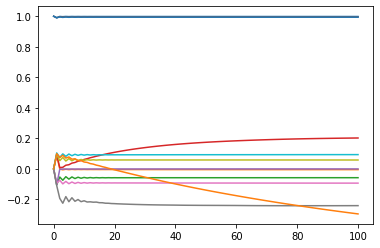

In [17]:
plt.plot(aligner.Ts);

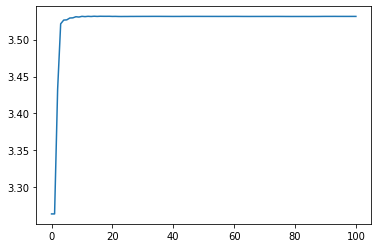

In [18]:
plt.plot(aligner.scores);

In [19]:
[[  9.69838248e-01   7.41253856e-02   2.32205080e-01  -3.58975061e+01]
 [ -7.00849620e-02   9.97212129e-01  -2.56138103e-02  -3.87932318e+01]
 [ -2.33456356e-01   8.56716872e-03   9.72329540e-01  -1.27806610e+01]]

SyntaxError: invalid syntax (<ipython-input-19-3fcfbf809cd4>, line 1)

In [ ]:
# doesn't display much
# Transform instances.
"""
T = convert_transform_forms(aligner=aligner, out_form=(3,4), select_best='max_value')

aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
transform_volume_v4((moving_instance_volume, (0,0,0)), transform=T,
                    return_origin_instead_of_bbox=True)

aligned_moving_instance_wrt_templateCentroid = (aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)        

# Generate meshes for each instance.

instance_mesh_wrt_templateCentroid_all_instances = [
volume_to_polydata((v, o), num_simplify_iter=3, smooth=True)
for v, o in 
[template_instance_wrt_templateCentroid] + [aligned_moving_instance_wrt_templateCentroid]]

launch_vtk([actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1) 
    for i, mesh in enumerate([instance_mesh_wrt_templateCentroid_all_instances[0],
                             instance_mesh_wrt_templateCentroid_all_instances[1]])], 
  background_color=(1,1,1))
"""

# Visualize Results

INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance1/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance2/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance3/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance4/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance5/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp


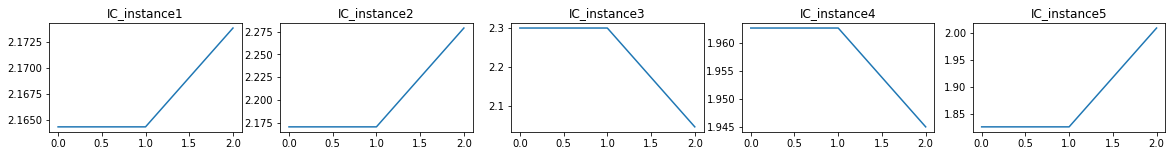

INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance1/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance2/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance3/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance4/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance5/annotationAsScoreVolume_warp108_annotationAsScoreVolume/scoreHistory.bp


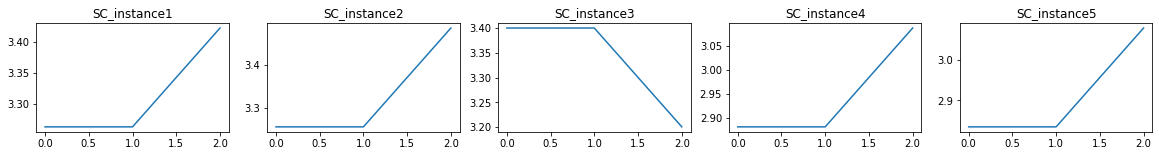

In [20]:
# for name_u in all_known_structures:
for name_u in structures:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
#         try:
        scores = load_alignment_results_v3(what='scoreHistory', alignment_spec=dict(warp_setting=108, 
                          stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                         stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                 reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')) 

        axes[i-1].plot(scores);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
    plt.show();

INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance1/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance2/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance3/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance4/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/IC_instance5/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp


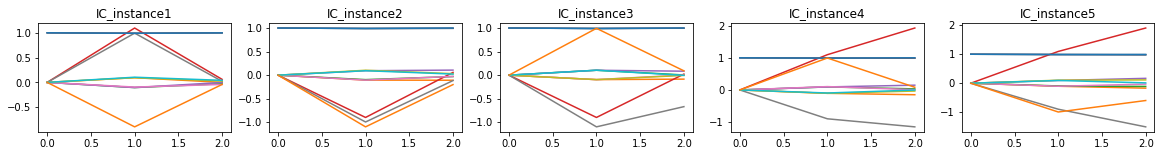

INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance1/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance2/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance3/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance4/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp
INPUT_KEY_LOC /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/instance_registration/SC_instance5/annotationAsScoreVolume_warp108_annotationAsScoreVolume/trajectory.bp


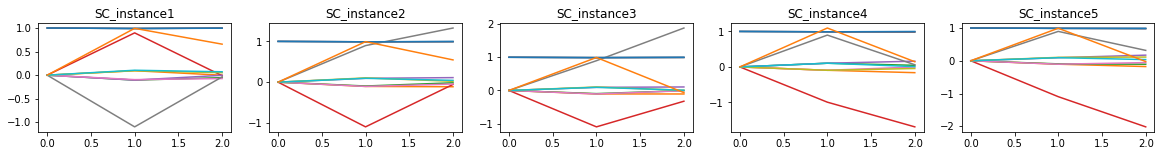

In [21]:
# for name_u in all_known_structures:
for name_u in structures:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
        trajectory = load_alignment_results_v3(what='trajectory',
                          alignment_spec=dict(warp_setting=108, 
                                              stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                                             stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                                     reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration'))        
        axes[i-1].plot(trajectory);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
    plt.show();

In [22]:
for name_u in structures:
    # Load instance meshes.
    instance_meshes = []
    for i in range(6):
        filepath = get_instance_mesh_filepath(atlas_name=atlas_name, structure=name_u,index=i, resolution='10um')
        m = load_data(filepath, filetype='stl')
        if m is not None:
            instance_meshes.append(m)

    #launch_vtk([actor_mesh(m, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1, wireframe_linewidth=3) 
    #    for i, m in enumerate(instance_meshes)], 
    #  background_color=(1,1,1))
    
    # Load average shape.
    filepath = get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='volume', resolution='10.0um')
    vol = load_data(filepath, filetype='stl')
    filepath = get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='origin_wrt_meanShapeCentroid', resolution='10.0um')
    ori_wrt_meanShapeCentroid = load_data(filepath, filetype='stl')
    
    standard_shape_volume_actor = actor_volume(vol.astype(np.float32), 
                                               what='probability', 
                                               origin=ori_wrt_meanShapeCentroid, 
                                              c=(0,0,0))
    
    #launch_vtk([standard_shape_volume_actor])

load_data: File does not exist: /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/aligned_instance_meshes/10um_IC_0.stl
File type stl not recognized.
load_data: File does not exist: /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/aligned_instance_meshes/10um_IC_1.stl
File type stl not recognized.
load_data: File does not exist: /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/aligned_instance_meshes/10um_IC_2.stl
File type stl not recognized.
load_data: File does not exist: /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/aligned_instance_meshes/10um_IC_3.stl
File type stl not recognized.
load_data: File does not exist: /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/aligned_instance_meshes/10um_IC_4.stl
File type stl not recognized.
load_data: File does not exist: /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/aligned_instance_meshes/10um_IC_5.stl
File type stl not recognized.


NameError: name 'get_mean_shape_filepath' is not defined

# Combine standard shapes with standard centroid locations

In [24]:
atlas_resolution = '10.0um'
atlas_resolution_um = 10.0

In [25]:
nominal_centroids_wrt_canonicalAtlasSpace_um = load_data(get_structure_mean_positions_filepath(atlas_name=atlas_name, resolution='1um'))
nominal_centroids_wrt_canonicalAtlasSpace_10um = {s: c / atlas_resolution_um for s, c in nominal_centroids_wrt_canonicalAtlasSpace_um.iteritems()}

mean_shapes_10um_wrt_stdShapeCentroid = {name_u: load_mean_shape(atlas_name=atlas_name, structure=name_u, resolution=atlas_resolution) 
                    for name_u in all_known_structures_unsided_including_surround_200um}

NameError: name 'get_structure_mean_positions_filepath' is not defined

In [ ]:
atlas_spec = dict(name=atlas_name, vol_type='score', resolution=atlas_resolution)

In [ ]:
## TODO: simplify this.
# mean_shape_wrt_canonicalAtlasSpace_all_structures_10um = {}
for name_u in structures:
# for name_u in ['7N']:
#     mean_shape_10um, mean_shape_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[name_u]
#     mean_shape_surround_10um, mean_shape_surround_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')]
    
    if name_u in singular_structures:                
        for name in [name_u, convert_to_surround_name(name_u, margin='200um')]:
            mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name][0], 
                        mean_shapes_10um_wrt_stdShapeCentroid[name][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[name_u])
            
#             mean_shape_wrt_canonicalAtlasSpace_all_structures_10um[name] = mean_shape_wrt_canonicalAtlasSpace_10um

            #save_original_volume(volume=mean_shape_wrt_canonicalAtlasSpace_10um, stack_spec=atlas_spec, structure=name, wrt='canonicalAtlasSpace')
            print('mean_shape_wrt', np.shape(mean_shape_wrt_canonicalAtlasSpace_10um))
    else:
        
        left_name = convert_to_left_name(name_u)
        left_surround_name = convert_to_surround_name(left_name, margin='200um')
        right_name = convert_to_right_name(name_u)
        right_surround_name = convert_to_surround_name(right_name, margin='200um')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(volume=mean_shapes_10um_wrt_stdShapeCentroid[name_u],
             centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[name_u][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])

        save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_name, wrt='canonicalAtlasSpace')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(\
            volume=mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0],
            centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])        
        
        save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_surround_name, wrt='canonicalAtlasSpace')
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name_u][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[name_u][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_name, wrt='canonicalAtlasSpace')
            
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        DataManager.save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_surround_name, wrt='canonicalAtlasSpace')

# Convert to vtk polydata for visualization

In [ ]:
#for name_s in all_known_structures_sided_including_surround_200um:
for name_s in structures:
    atlas_structure_wrt_canonicalAtlasSpace = \
    load_original_volume_v2(stack_spec=atlas_spec, structure=name_s, bbox_wrt='canonicalAtlasSpace')

    for surface_level in np.arange(0.1, 1.1, .1):
        mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace = \
        volume_to_polydata(volume=(atlas_structure_wrt_canonicalAtlasSpace[0] >= surface_level, atlas_structure_wrt_canonicalAtlasSpace[1]), 
                     num_simplify_iter=3, smooth=True, 
                     return_vertex_face_list=False)

        #save_data(mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace, 
        #          DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=surface_level))

In [ ]:
mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures = \
{name_s: load_data(DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=0.5))
for name_s in all_known_structures_sided}

In [ ]:
#launch_vtk([actor_mesh(v, wireframe=False, opacity=.5, color=name_unsided_to_color_float[convert_to_original_name(s)]) 
#            for s, v in mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
#          + [actor_sphere([0,0,0])])

# Shell

Just use MD589's shell, until we find a way to average the outlines.

In [41]:
stack_fixed = 'MD589'
margin_um = 200
margin_tb = margin_um / XY_PIXEL_DISTANCE_TB
# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD589']:
    sqlController = SqlController(stack)
#     contours_valid_by_z = {}
    contour_prob_maps_by_sec = {} 
    sections = sqlController.get_sections_dict(stack)
    for sec in sections:
        m = load_thumbnail_mask_v3(stack, prep_id=2, section=sec)
        print(type(m))
        contours = find_contour_points(m, sample_every=1)[1]
        contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]
        
#         z = np.mean(DataManager.convert_section_to_z(stack, sec, downsample=32, z_begin=0))
#         contours_valid_by_z[z] = contours_valid[0]
        
        m2 = np.zeros_like(m, np.bool)
        for cnt in contours_valid:
            m2[cnt[:,1], cnt[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        contour_prob_map = np.exp(-distance_to_contour**2/(2*margin_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0
        contour_prob_maps_by_sec[sec] = contour_prob_map
        
outline_prob_volume_atlasResol, outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol = \
images_to_volume_v2(images=contour_prob_maps_by_sec, spacing_um=20, 
                    in_resol_um=convert_resolution_string_to_um(resolution='down32', stack=stack_fixed),
                    out_resol_um = atlas_resolution_um)
                                                                    
# outline_prob_volume_bbox (xm,xm,ym,ym) relative to cropped, (zm,zm) relative to uncropped.

# crop_box = metadata_cache['cropbox']['MD589']
alignedBrainstemCrop_cropbox_down32 = load_cropbox_v2(stack=stack_fixed, prep_id='alignedBrainstemCrop')
alignedBrainstemCrop_cropbox_atlasResol = alignedBrainstemCrop_cropbox_down32 * convert_resolution_string_to_um('down32', stack=stack_fixed) / atlas_resolution_um

outline_prob_volume_origin_rel2fixedwholebrain_atlasResol = outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol + (alignedBrainstemCrop_cropbox_atlasResol[0], alignedBrainstemCrop_cropbox_atlasResol[2], 0)

display_volume_sections(outline_prob_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)

IndexError: too many indices for array

In [ ]:
outline_prob_volume_origin_rel2canon_atlasResol = outline_prob_volume_origin_rel2fixedwholebrain_atlasResol - \
canonical_center_wrt_fixed_um/convert_resolution_string_to_um(resolution='10.0um')

In [ ]:
shell_vol_origin_dict_rel2canon = {'shell': (outline_prob_volume_atlasResol, outline_prob_volume_origin_rel2canon_atlasResol)}

# Side task: compute the volumes of structures

In [43]:
atlas_resolution = '10.0um'
atlas_resolution_um = 10.0
atlas_spec = dict(name='atlasV7', vol_type='score', resolution=atlas_resolution)
volumes = load_original_volume_all_known_structures_v3(atlas_spec, 
                           structures=all_known_structures_sided,in_bbox_wrt='wholebrain')

volumes_mm3 = defaultdict(dict)
for name_u in all_known_structures:
    for level in np.arange(0, 1.1, .1):
        volumes_mm3[name_u][level] = np.count_nonzero(volumes[convert_to_left_name(name_u)][0] > level) * 10.**3 / 1e9

vol_basename1 


Prior structure/index map not found. Generating a new one.


OSError: /net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/10.0um_scoreVolume/5N_L_origin_wrt_wholebrain.txt not found.

In [ ]:
DataFrame(volumes_mm3).to_csv('/home/yuncong/structure_volumes_mm3.csv')

# Load

In [ ]:
standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.5, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

In [ ]:
launch_vtk([actor_mesh(p, wireframe=True) 
           for s, p in standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Show multiple iso-surfaces

standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.1, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.9, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Load shell

stack_fixed = 'MD589'
shell_polydata_rel2fixedWholebrain = DataManager.load_mesh_v2(brain_spec={'name':stack_fixed, 
                                                                    'vol_type':'annotationAsScore',
                                                                   'resolution':'10.0um'}, 
                                                        structure='shell')

shell_polydata_rel2canonicalAtlasSpace = move_polydata(shell_polydata_rel2fixedWholebrain,
                                                       -canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

shell_actor_rel2canon = actor_mesh(shell_polydata_rel2fixedWholebrain, (1,1,1), opacity=.15, 
                              wireframe=False, origin=-canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

In [ ]:
save_data(shell_polydata_rel2canonicalAtlasSpace, 
          DataManager.get_mesh_filepath_v2(atlas_spec, structure='shell', level=None))

In [ ]:
launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)]\
#           +[shell_actor_rel2canon] \
           +[actor_mesh(shell_polydata_rel2canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)]
#           +[actor_volume(shell_vol_origin_dict_rel2canon['shell'][0].astype(np.float32), 
#                          what='probability', origin=shell_vol_origin_dict_rel2canon['shell'][1])]
          )

In [ ]:
# atlas_volume, structure_to_label, label_to_structure = \
# DataManager.load_original_volume_all_known_structures(stack=atlas_name, sided=True)

In [ ]:
vol, origin_rel2canon = structure_vol_origin_dicts_rel2canon['7N_L']

one_structure_volume_actor_rel2canon = actor_volume(vol.astype(np.float32), what='score', 
                                              origin=origin_rel2canon,
                                                    auxdata=0.8*(vol>0.1).astype(np.float32),
                                              c=np.array(name_unsided_to_color['7N'])/255.)
#                                             c=np.array((1,0,0)))

# Render

In [ ]:
launch_vtk([] \
    + structure_mesh_actors_rel2canon \
#     + [one_structure_volume_actor_rel2canon] \
#     + [shell_volume_actor_rel2canon] \
#     + structure_mesh_surround_actors_rel2canon \
    + [shell_actor_rel2canon] \
    + [actor_sphere((0,0,0), radius=1)], 
           init_angle='sagittal', 
    background_color=(1,1,1),
depth_peeling=True)